# Spritz MBHB search + imputation (time-domain approach)

Let's try to  replicate `MBHB-search-dev-globe.ipynb` with time-domain data and with Spritz data (MBHB-1 dataset).

E Castelli - 2022

## Table of contents

0. Settings and package import
1. Load time-domain LDC data
2. Build orthogonal TDI combinations
3. Data pre-processing before gap-imputation
4. Gap imputation with custom gaps
    1. noise-only `n` data
    2. noise + signal `n + s` data
5. Analysis of Spritz data

## 0. Settings and package import

In [1]:
# Python standard packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.signal
import h5py
import time
from pyfftw.interfaces.numpy_fft import fft, ifft
from scipy import interpolate
from scipy import optimize



In [2]:
# Custom LISA Data Analysis packages 
from ldc.lisa.noise import get_noise_model
from ldc.common import tools
from ldc.common.constants import ldc_cosmo as cosmo
from ldc.common.series import TimeSeries, FrequencySeries, TDI
from ldc.common.tools import compute_tdi_snr, window
from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain
from ldc.lisa.noise import AnalyticNoise, get_noise_model
from ldc.waveform.lisabeta import FastBHB

import lisabeta.lisa.ldcnoise as ldcnoise
from bayesdawn import datamodel, psdmodel
import lisaorbits

MLDC modules could not be loaded.


In [3]:
# define function to print all attributes of hdf5 file recursively
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")

## 1. Load time-domain LDC data

We are currently interested only in the impact of gaps on the Spritz MBHB-1 dataset. In order to do that, we separate the effect of glitches from the effect of gaps in the Spritz data.

### 1.1. Download and access data

Download LDC 2b *Spritz* MBHB-1 data from the LDC official website (https://lisa-ldc.lal.in2p3.fr/challenge2b) and save them to the `./data/` folder.

In [4]:
# import data
fname = '../data/LDC2_spritz_mbhb1_training_v2.h5'
# open file with h5py
fid = h5py.File(fname)
# print all dataset attributes
# fid.visititems(print_attrs)
cfg = dict(zip(fid["obs/config"].keys(), [v[()] for v in fid["obs/config"].values()]))

#### 1.1. Import LDC data
Import the existing TDI datasets and build the missing TDI dataset

Existing:
- TDI dataset `obs` containing `noise + signal + artifacts` (gaps + glitches)
- TDI dataset `clean` containing `noise + signal`
- TDI dataset `sky` containing `signal`
- TDI dataset `noisefree` containing `signal + artifacts` (gaps + glitches)

Missing:
- TDI dataset containing `noise`
- TDI dataset containing `noise + signal + gaps`

In [5]:
from bayesdawn.connect.fillgaps import load_tdi_timeseries

In [6]:
tdidata = load_tdi_timeseries(fname = fname)

In [7]:
# set up dataset constant values
skip = 100 
# skipb = 100 
ndata = len(tdidata['obs'][skip:])
dt = tdidata['obs']['t'][1]-tdidata['obs']['t'][0]
fs = 1.0/dt

# print('skip','ndata','dt', 'fs',sep='\t',end='\n------------------------------\n')
# print(skip, ndata, dt, fs,sep='\t')

#### 1.3. Plot imported data:
- Datasets containing NO noise artifacts: `n+s`, `s`, `n`
- Dataset with artifacts: `n+s+g+gl`, `n+s+g`,`s+g+gl`
    
Useful LDC-provided resources and code bits to importing Spritz data taken from here: https://gitlab.in2p3.fr/LISA/LDC/-/blob/develop/notebooks/LDC2b-Spritz.ipynb

In [8]:
# avgwin = 'nuttall'
avgwin = 'hann'

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

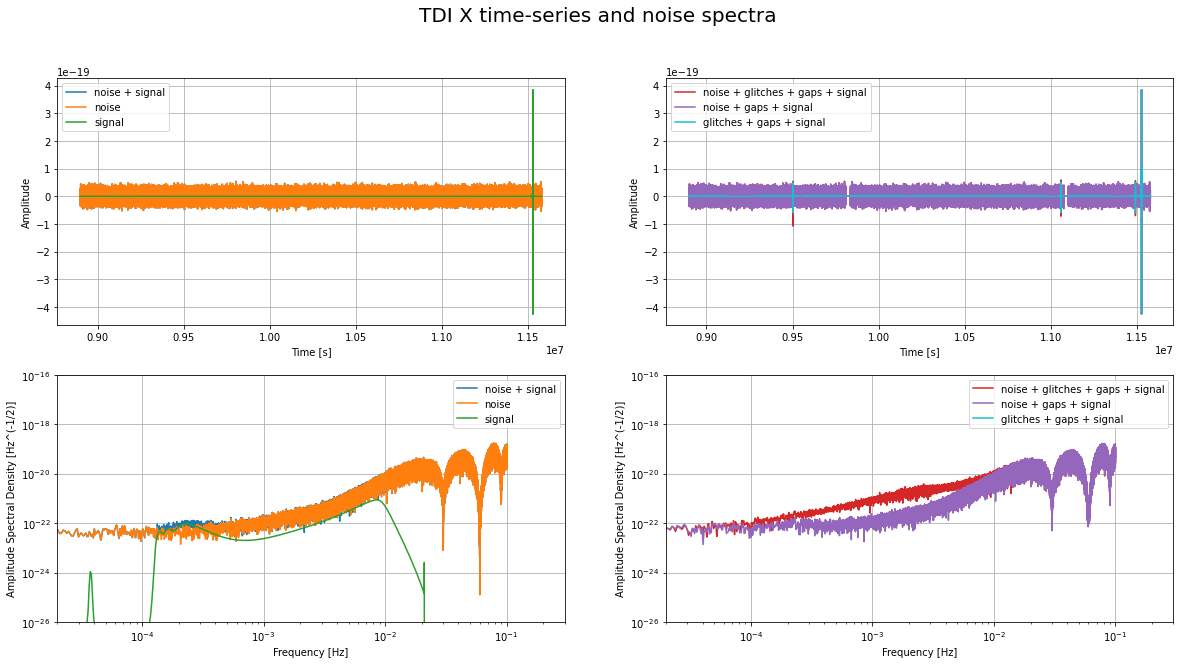

In [9]:
# plot TDI X time-series and noise spectra for all different configurations

fig, ax = plt.subplots(2, 2, figsize=(20,10))
# top left canvas
ax[0][0].plot(tdidata['clean']['t'][skip:], tdidata['clean']["X"][skip:], label = 'noise + signal')
ax[0][0].plot(tdidata['noise']['t'][skip:], tdidata['noise']["X"][skip:], label='noise')
ax[0][0].plot(tdidata['sky']['t'][skip:], tdidata['sky']["X"][skip:], label='signal')
ax[0][0].set_ylabel("Amplitude")
ax[0][0].set_xlabel("Time [s]")
ax[0][0].grid()
ax[0][0].legend()
# top right canvas
ax[0][1].plot(tdidata['obs']['t'][skip:], tdidata['obs']["X"][skip:], label='noise + glitches + gaps + signal', color='tab:red')
ax[0][1].plot(tdidata['clean_gapped']['t'][skip:], tdidata['clean_gapped']["X"][skip:], label='noise + gaps + signal', color='tab:purple')
ax[0][1].plot(tdidata['noisefree']['t'][skip:], tdidata['noisefree']["X"][skip:], label='glitches + gaps + signal', color='tab:cyan')
ax[0][1].set_ylabel("Amplitude")
ax[0][1].set_xlabel("Time [s]")
ax[0][1].grid()
ax[0][1].legend()
# bottom left canvas
f, psdX =  scipy.signal.welch(tdidata['clean']["X"][skip:], fs=1.0/dt, window=avgwin, nperseg=ndata//2)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'noise + signal')
f, psdX =  scipy.signal.welch(tdidata['noise']["X"][skip:], fs=1.0/dt, window=avgwin, nperseg=ndata//2)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'noise')
f, psdX =  scipy.signal.welch(tdidata['sky']["X"][skip:], fs=1.0/dt, window=avgwin, nperseg=ndata//2)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'signal')
ax[1][0].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1][0].set_xlabel("Frequency [Hz]")
ax[1][0].grid()
ax[1][0].legend()
ax[1][0].set_ylim([1e-26,1e-16])
ax[1][0].set_xlim([2e-5,0.3])

# bottom right canvas
tdix_wo_nan = tdidata['obs']["X"].copy()
tdix_wo_nan[np.isnan(tdidata['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdix_wo_nan[skip:], fs=1.0/dt, window=avgwin, nperseg=ndata//2)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'noise + glitches + gaps + signal', color='tab:red')

tdigapped_wo_nan = tdidata['clean_gapped']["X"].copy()
tdigapped_wo_nan[np.isnan(tdidata['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdigapped_wo_nan[skip:], fs=1.0/dt, window=avgwin, nperseg=ndata//2)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'noise + gaps + signal', color='tab:purple')

tdinoise_wo_nan = tdidata['noisefree']["X"].copy()
tdinoise_wo_nan[np.isnan(tdidata['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdinoise_wo_nan[skip:], fs=1.0/dt, window=avgwin, nperseg=ndata//2)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'glitches + gaps + signal', color='tab:cyan')

ax[1][1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1][1].set_xlabel("Frequency [Hz]")
ax[1][1].grid()
ax[1][1].legend()
ax[1][1].set_ylim([1e-26,1e-16])
ax[1][1].set_xlim([2e-5,0.3])

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)
# fig.tight_layout()

## 2. Build orthogonal TDI combinations

### 2.1. Build orthogonal TDI combinations for `n+s` data. 

Check that explicit evaluation of orthogonal TDI combinations is equivalent to evaluation inside LDC functions.

In [10]:
from bayesdawn.connect.fillgaps import build_orthogonal_tdi

In [11]:
datans = build_orthogonal_tdi(tdidata['clean'])

Compare my evaluation to LDC conversion function, just to be on the safe side of things.

### 2.2. Build orthogonal TDI combinations for `s`, `n`, `n+s+g` data. 


In [12]:
datas  = build_orthogonal_tdi(tdidata['sky'])
datan  = build_orthogonal_tdi(tdidata['noise'])
datag  = build_orthogonal_tdi(tdidata['clean_gapped'])
datang = build_orthogonal_tdi(tdidata['noise_gapped'])
dataobs = build_orthogonal_tdi(tdidata['obs'])

### 2.3. Define useful functions 

All these will end up in a separate file afterwards.

- `fft_olap_psd`: function that evaluates PSD equivalent to `scipy.signal.welch` and also evaluates FFT at the same time
- `generate_freq_data`: function that applies `fft_olap_psd` to each group inside data and groups results in a single `numpy.recarray` with the same structure of time-domain data.
- `plot_compare_spectra_timeseries`: modified version of `lisabeta_fill_gaps.plot_compare_spectra` function that plots noise spectra and distribution of real/imag part of PSD/noise_model

### 2.4 Data quicklook
#### 2.4.1 Test PSD and FFT evaluation function

In [13]:
from bayesdawn.connect.fillgaps import fft_olap_psd, generate_freq_data, plot_compare_spectra_timeseries

#### 2.4.2 Define LISA noise model
Import noise model for Spritz data from LDC toolbox.

/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


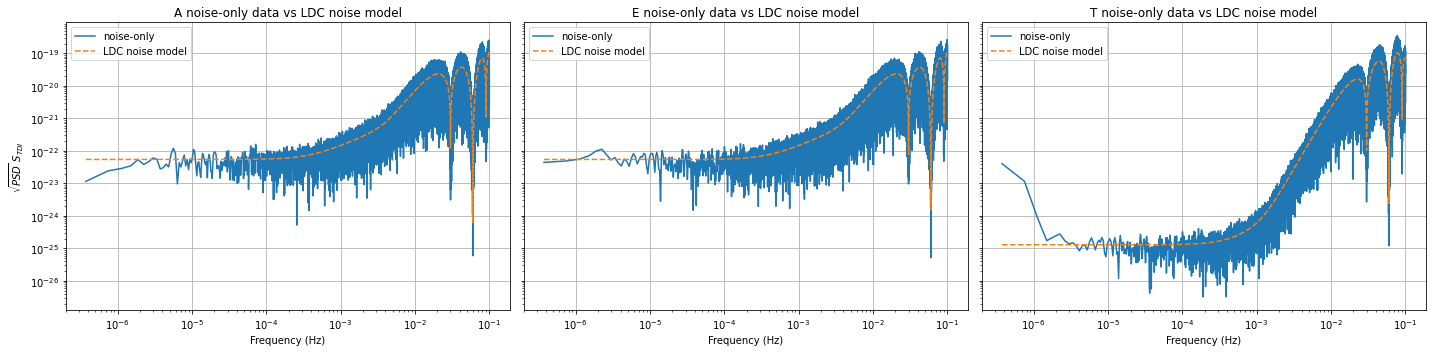

In [14]:
#Load some noise models from lisabeta
# import lisabeta.lisa.pyLISAnoise as pyLISAnoise

LISAnoise={'InstrumentalNoise': 'SciRDv1', 
           'WDbackground': False, 
           'WDduration': 0.0, 
           'lowf_add_pm_noise_f0': 0.0, 
           'lowf_add_pm_noise_alpha': 2.0}
# LISAnoise={'InstrumentalNoise': 'Proposal', 
#            'WDbackground': True, 
#            'WDduration': 3.0, 
#            'lowf_add_pm_noise_f0': 0.0, 
#            'lowf_add_pm_noise_alpha': 2.0}

# eval psd of noise data
fdatan, psddatan, fftscalefac = generate_freq_data(datan)
# noise models for A, E, T
 # Comparison with LISA Orbits
orbits = lisaorbits.KeplerianOrbits(dt=cfg['dt_orbits'], 
                                    L=cfg['nominal_arm_length'], 
                                    a=149597870700.0, 
                                    lambda1=0, 
                                    m_init1=0, 
                                    kepler_order=cfg['kepler_order'])
noise_model = "spritz"
S = {}
Nmodel = get_noise_model(noise_model, fdatan['f'], wd=0, orbits=orbits, t_obs=ndata*dt)
for tdi in ['A', 'E', 'T']:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan['f'], equal_arms=False)
# plot data
fig, ax = plt.subplots(1,3,figsize=(20,5),sharey=True)
for tdi in S.keys(): 
    ax[list(S.keys()).index(tdi)].set_title('{tdi} noise-only data vs LDC noise model'.format(tdi=tdi))
    ax[list(S.keys()).index(tdi)].loglog(fdatan['f'], np.sqrt(psddatan[tdi]), label='noise-only')
    ax[list(S.keys()).index(tdi)].loglog(fdatan['f'], np.sqrt(S[tdi]), ls='--', label='LDC noise model')
    ax[list(S.keys()).index(tdi)].set_xlabel('Frequency (Hz)')
    ax[list(S.keys()).index(tdi)].grid()
    ax[list(S.keys()).index(tdi)].legend()

ax[0].set_ylabel(r'$\sqrt{PSD}$ $S_{TDI}$')
fig.tight_layout()
# plt.suptitle('Comparison between TDI of noise-only Spritz data vs noise models');

#### 2.4.3 Plot comparison between spectra and FFT distribution

/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/numpy/lib/histograms.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


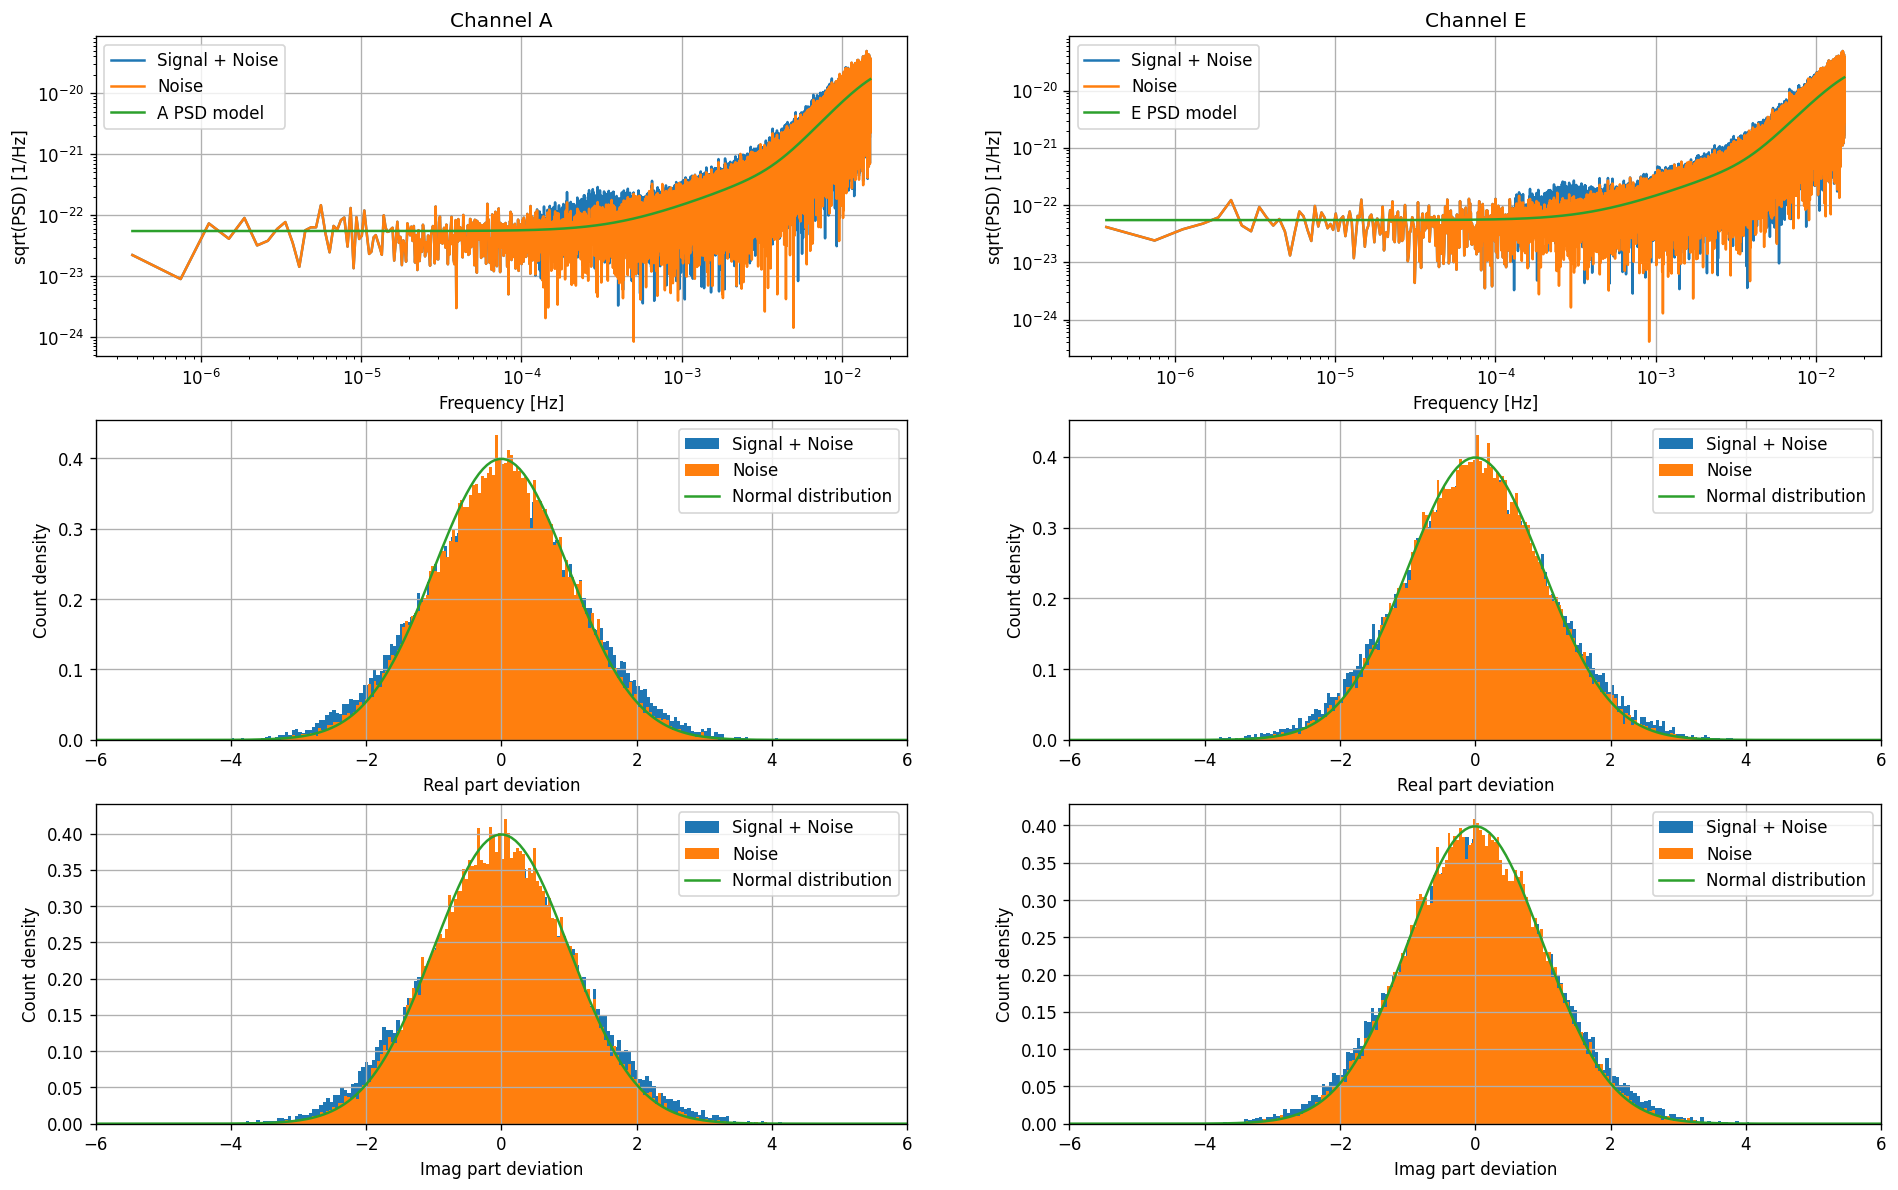

In [15]:
fmax = 1.5e-2
plot_compare_spectra_timeseries(data = [datans, datan], 
                                noise_models = [S.get(key) for key in ['A','E']], 
                                fmax = fmax)

## 4. Gap imputation on Spritz data with PSD estimation

In [16]:
# import lisabeta_fill_gaps as fill_gaps
from bayesdawn.connect.fillgaps import construct_gap_mask

Here we compare the full noise + signal dataset with the only-noise dataset, applying `LISAnoise` as noise model for the TDI noise spectra.

### 4.1 Noise-only `n` data
We'll first apply imputation to noise-only `n` data in the `datan` dataset.

For gapped data we'll be using the `datang` dataset, containing the Sprtiz noise-only data with gaps `n + g`.


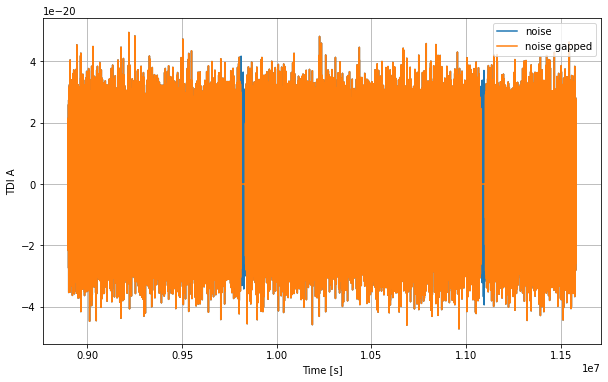

In [17]:
# compare noise full data and noise gapped data
fig, ax = plt.subplots(1, 1, figsize=(10,6))
# top left canvas
ax.plot(datan['t'], datan['A'], label='noise')
ax.plot(datang['t'], datang['A'], label='noise gapped')
ax.set_xlabel('Time [s]')
ax.set_ylabel('TDI A')
ax.grid()
ax.legend()

In [18]:
# reset time-series information data
ndata = datang.shape[0]
dt = datang['t'][1]-datang['t'][0]
fs = 1/(datang['t'][1]-datang['t'][0])

print('ndata','dt', 'fs',sep='\t',end='\n---------------------\n')
print(ndata, dt, fs,sep='\t')

fdatan, psddatan, fftscalefac = generate_freq_data(datan)
fdatang, psddatang, fftscalefac = generate_freq_data(datang)

ndata	dt	fs
---------------------
535580	5.0	0.2


#### 4.1.2. Define function to visualize gaps in time-domain

Slightly modified version of `lisabeta_fill_gaps.view_gaps`.

In [19]:
from bayesdawn.connect.fillgaps import view_gaps

#### 4.1.3 Set up PSD Spritz noise model

We'll end up not using this noise model in the gap imputation, but this might be useful for other purposes (or once the Spritz noise model is fixed).

In [20]:
from bayesdawn.connect.fillgaps import LDCModelPSD, LDCCorrectedModelPSD

Let's take a look at the model w.r.t downaveraged data.

We also need to generate the Spritz gap mask.

In [21]:
from bayesdawn.connect.fillgaps import get_ldc_gap_mask

In [22]:
mask = np.ones(datang.shape[0])
ndata = datang.shape[0]

spritzgaps = get_ldc_gap_mask(dataobs, mode='index')
gapstarts,gapends= np.vsplit(spritzgaps, 2)

for k in range(gapstarts.shape[1]):
    mask[gapstarts.reshape((2))[k]:gapends.reshape((2))[k]]=0

spritzmask = {'mask': mask,
              'starts': gapstarts.reshape((2)),
              'ends': gapends.reshape((2))}

figname = 'figures/nodownavg_spritzgaps'

Text(0, 0.5, 'Spritz gap mask')

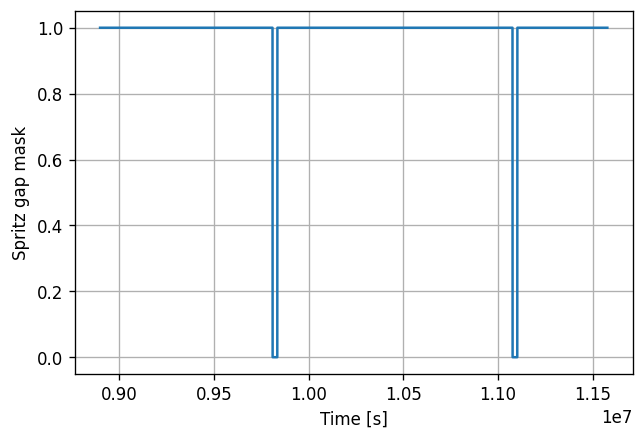

In [23]:
fig,ax = plt.subplots(1,1,dpi=120)
# ax.plot(maskinfo['mask'])
ax.plot(datan['t'],spritzmask['mask'])
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Spritz gap mask')

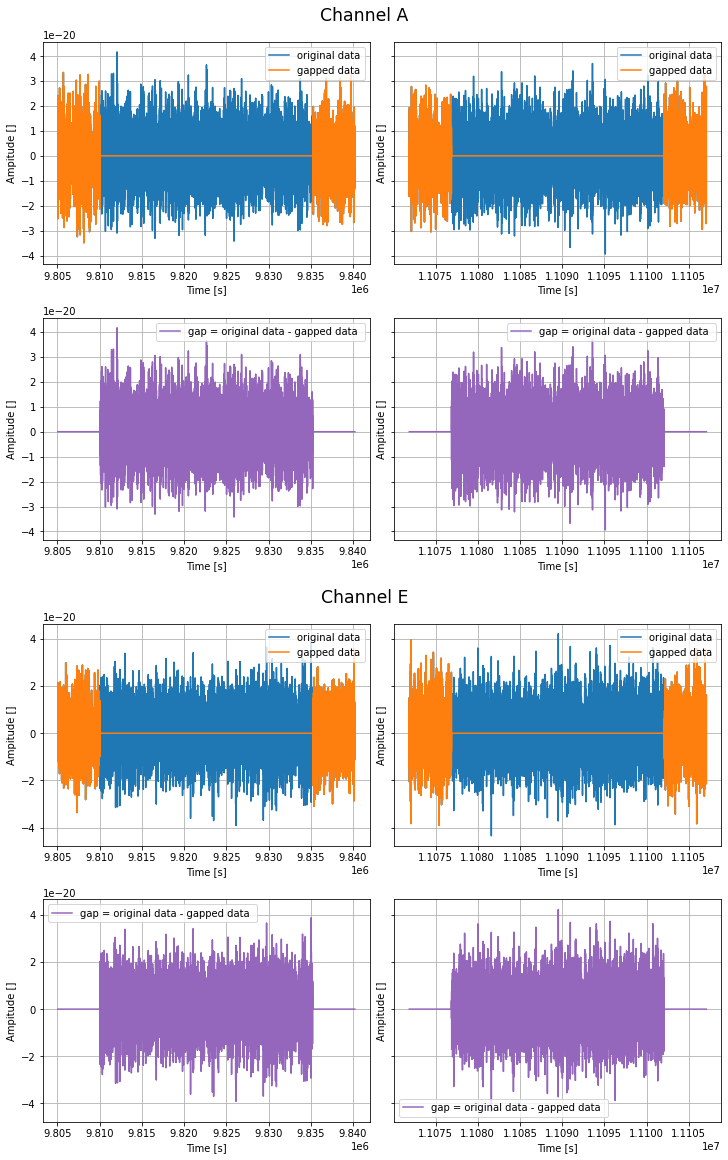

In [24]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datang.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data'], nwing = 1000)

#### 4.1.4 Import PSD freq domain estimation tool
Import John's frequency domain PSD estimation tool.

In [25]:
import bayesdawn.connect.fillgaps as fillgaps
from bayesdawn.connect.fillgaps import makeFDdata


#### 4.1.5 Set up LDC noise model for PSD-0

In [26]:
def choose_frequency_knots(n_knots, freq_min=1e-5, freq_max=1.0, base=10):
    # Choose the frequency knots
    ns = - np.log(freq_min) / np.log(base)
    n0 = - np.log(freq_max) / np.log(base)
    jvect = np.arange(0, n_knots)
    alpha_guess = 0.8
    targetfunc = lambda x: n0 - (1 - x ** (n_knots)) / (1 - x) - ns
    result = optimize.fsolve(targetfunc, alpha_guess)
    alpha = result[0]
    n_knots = n0 - (1 - alpha ** jvect) / (1 - alpha)
    f_knots = base ** (-n_knots)
    f_knots = f_knots[(f_knots > freq_min) & (f_knots < freq_max)]
    
    return np.unique(np.sort(f_knots))

# Embed the PSD function in a class
# psdmodel is imported from bayesdawn
class LDCModelPSD0(psdmodel.PSD):
    '''
    Specialization of the bayesdawn psd model class which connects LDC noise models to lisabeta PSD models.
    
    Parameters
    ----------
    n_data : array_like
        vector of size N_DSP continaing the noise DSP calculated at frequencies
        between -fe/N_DSP and fe/N_DSP where fe is the sampling frequency and N
        is the size of the time series (it will be the size of the returned
        temporal noise vector b)
    fs : scalar integer
        Size of the output time series
    noise_model : scalar float
        sampling frequency
    channel : string
        seed of the random number generator

    Returns
    -------
        bf : numpy array
        frequency sample of the colored noise (size N)
    '''

    def __init__(self, ndata, fs, noise_model, channel, fmin=None, fmax=None, config = cfg):
        # instantiates the PDS estimator from function psdmodel.PSD
        self.noise_model = noise_model
        self.channel = channel
        psdmodel.PSD.__init__(self, ndata, fs, fmin=None, fmax=None)
        if fmax is not None:
            self.f = self.f[self.f<fmax]

    def psd_fn(self, x):
        # returns the psd function defined earlier
        tobs = ndata / fs
        orbits = lisaorbits.KeplerianOrbits(dt=cfg['dt_orbits'], 
                                    L=cfg['nominal_arm_length'], 
                                    a=149597870700.0, 
                                    lambda1=0, 
                                    m_init1=0, 
                                    kepler_order=cfg['kepler_order']) 
        
        Nmodel = get_noise_model(self.noise_model, x, wd=0, orbits=orbits, t_obs=tobs)
        return Nmodel.psd(tdi2=True, option=self.channel, freq=x, equal_arms=False)

#### 4.1.6 Perform data imputation with LDC noise model

In [27]:
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []

names=['A', 'E', 'T']
# set up flags and variables
mask = spritzmask['mask']
datang_rec = datang.copy()
    
# instantiate the PSD noise class
for tdi in names:
    psd_cls.append(LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))

(0.0, 200.0)

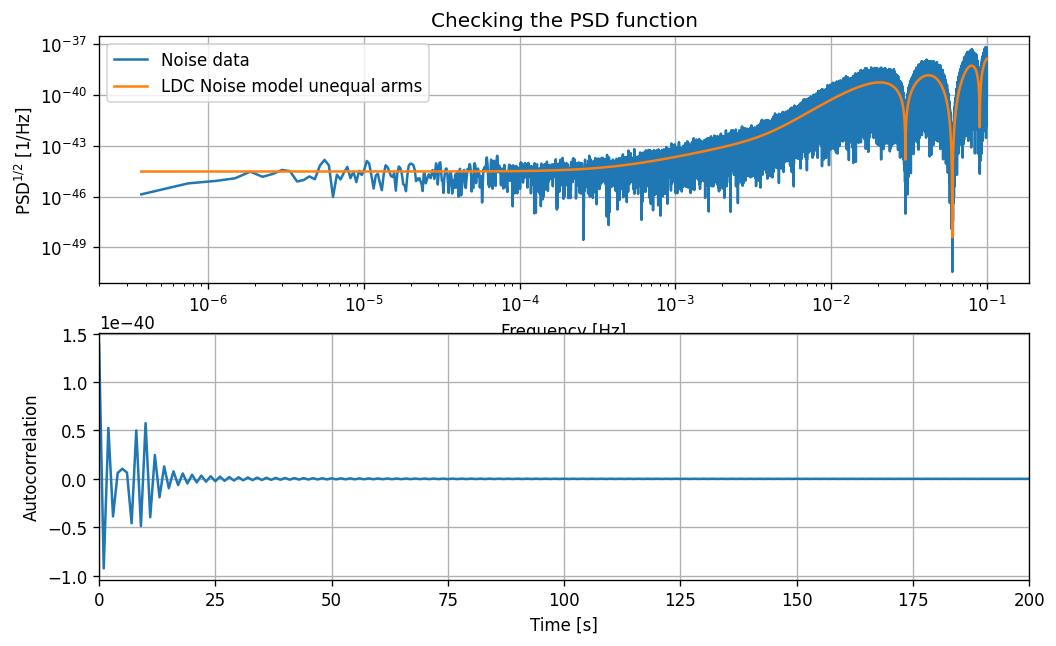

In [28]:
# Plot data against PSD
fig, ax = plt.subplots(2, 1, figsize=(10,6),dpi=120)
ax[0].set_title(r"Checking the PSD function")
ax[0].set_xlabel(r"Frequency [Hz]")
ax[0].set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
ax[0].loglog(psddatan['f'], (psddatan['A']), label="Noise data")
ax[0].loglog(psddatan['f'], psd_cls[0].psd_fn(psddatan['f']), label="LDC Noise model unequal arms")
# ax.loglog(psddatang['f'], (psddatang['A']), label="Noise")
ax[0].grid()
ax[0].legend()

# look at the psd autocorrelation to assess the width of the nearest region
ax[1].plot(psd_cls[0].calculate_autocorr(ndata))
ax[1].grid()
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Autocorrelation')
ax[1].set_xlim([0, 200])

In [29]:
# Perform data imputation WITHOUT loop
### NB this can be streamlined a little bit more and/or transformed into a function 
for tdi in range(len(names)):
    y_masked = datang[names[tdi]]
    s = np.zeros(len(mask))  # for residual 'signal' is zero
    # instantiate imputation class
    imp_cls += [datamodel.GaussianStationaryProcess(s, mask, psd_cls[tdi], method='nearest', na=150, nb=150)]
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(mask*(y_masked - s)).T) # (ymasked - s)
    t1 = time.time()
    # Don't update PSD
    imp_cls[tdi].update_psd(psd_cls[tdi])
    # Re-compute of PSD-dependent terms
    imp_cls[tdi].compute_offline()
    # Imputation of missing data by randomly drawing from their conditional distribution
    y_rec = imp_cls[tdi].impute(y_masked, draw=True)
    # Update the data residuals
    y_res = y_rec - s
    # Update the data residuals
    t2 = time.time()
    datang_rec[names[tdi]] = y_res

/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/bayesdawn-0.1.0-py3.10.egg/bayesdawn/datamodel.py:340: UserWarning: The maximum size of gap + conditional is high.


Computation of autocovariance + PSD took 6.316136837005615
Computation of autocovariance + PSD took 6.241490125656128
Computation of autocovariance + PSD took 6.173785924911499


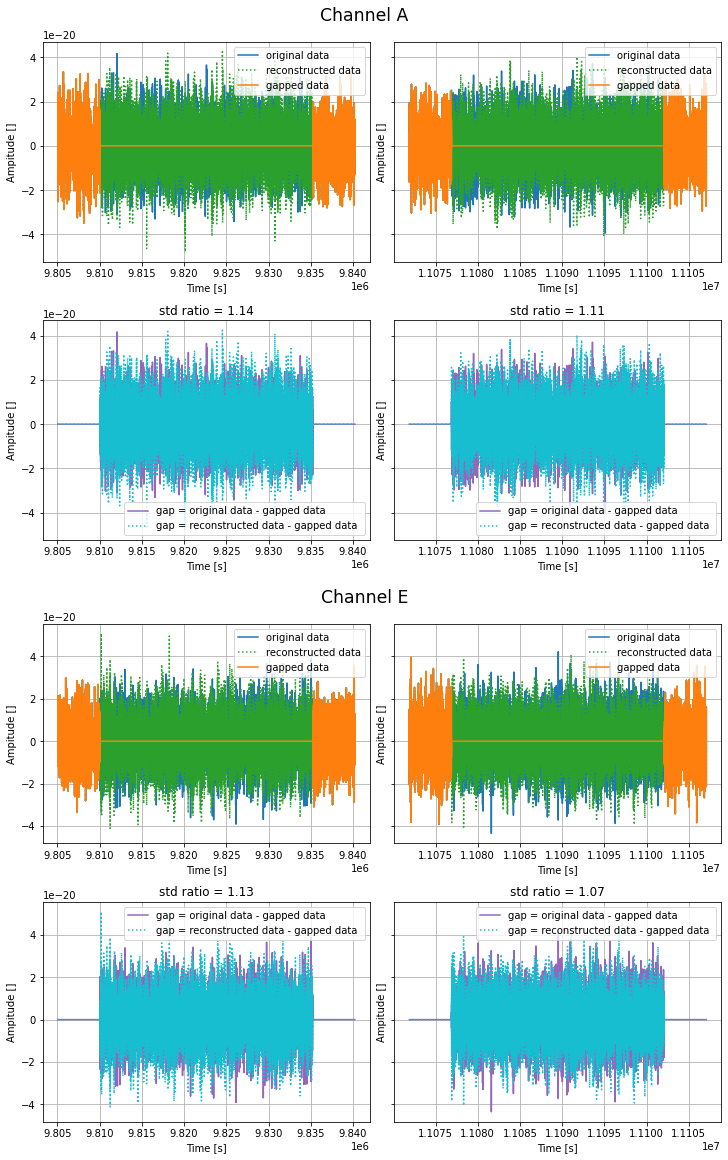

In [30]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=1000)

In [31]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

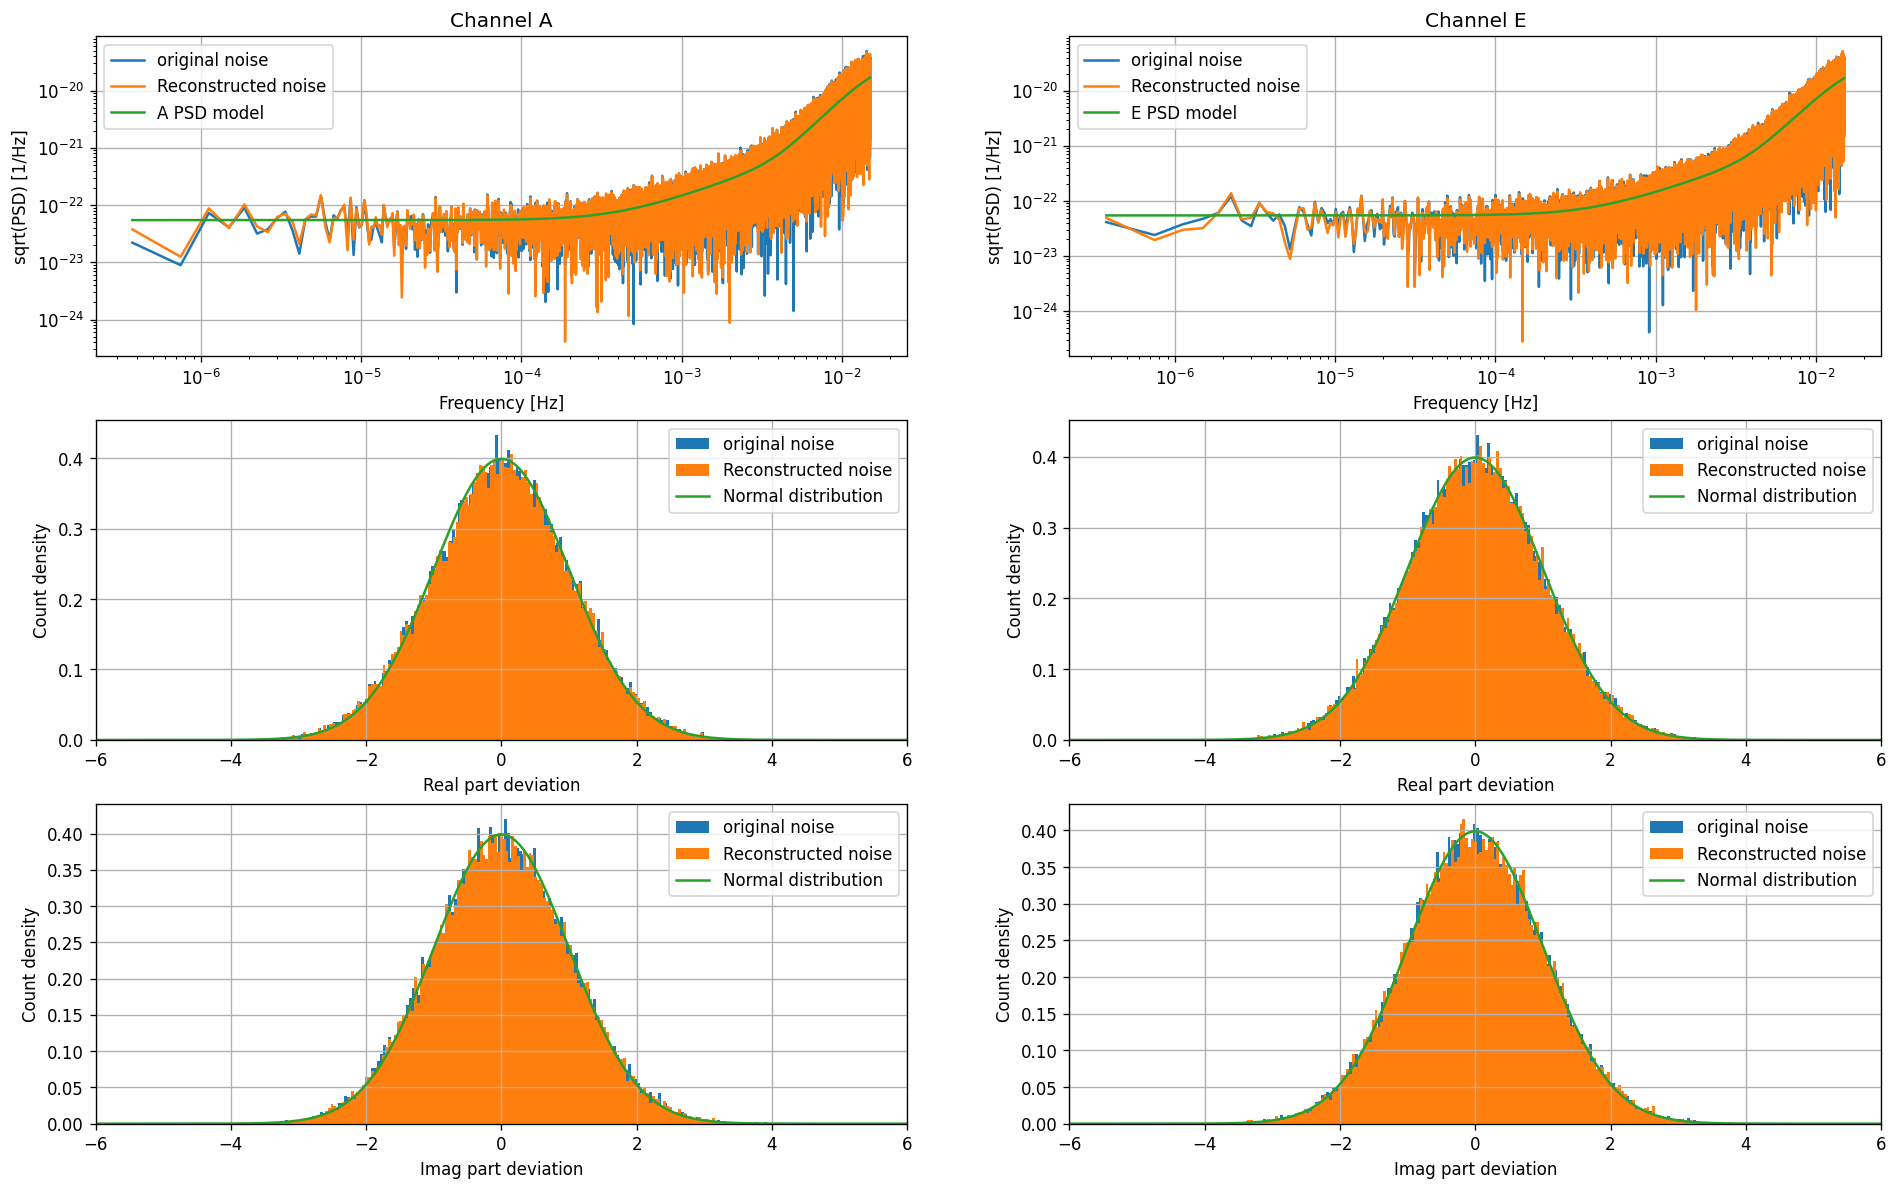

In [32]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                noise_models = [S.get(key) for key in ['A','E']],
                                fmax = 1.5e-2,
                               labels = ['original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### 4.1.7 Perform data imputation with freq-domain PSD estimation

In [33]:
from bayesdawn import datamodel, psdmodel

In [34]:
#Transform LDC data to Fourier domain
def makeFDdata(data, output_channels = None):
    t = data['t']
    del_t = ( t[-1] - t[0] ) / ( len(t) - 1 )
    #print('del_t',del_t)
    if isinstance(data,dict): 
        chans = list(data.keys())
    elif isinstance(data,(np.ndarray,np.recarray)):
        chans = list(data.dtype.fields.keys())
    chans.remove('t')
    #print('channel names are',chans)
    chandata = [ data[ch] for ch in chans ]
    newchans = ['f'] + chans
    #print('newchans',newchans)
    chFT = [np.fft.rfft(data[ch]*del_t).conj() for ch in chans]
    Nf=len(chFT[0])
    df=0.5/del_t/(Nf-1)
    #print(df,1/del_t/len(t))
    fr=np.arange(Nf)*df
    fdata = np.rec.fromarrays([fr]+chFT, names = newchans)
    if t[0]!=0 and False:
        for ch in chans:
            #print(fdata['f'].shape,fdata[ch].shape)
            fdata[ch]*=np.exp(-1j*2*np.pi*fdata['f']*t[0])
    #print(fdata.shape)
    #print(fdata.dtype)
    if output_channels is None:
        return fdata      
    else:
        return fdata[output_channels]

#Corresponding inverse transform
def makeTDdata(data,t0=0,flow=None, output_channels=None):
    print('f0',data['f'][0])
    del_t = 0.5/data['f'][-1]
    if isinstance(data,dict): 
        chans = list(data.keys())
    elif isinstance(data,(np.ndarray,np.recarray)):
        chans = list(data.dtype.fields.keys())
    chans.remove('f')
    #print('channel names are',chans)
    if flow is not None:
        f=data['f']
        window=np.ones_like(f)
        window[f<flow]=(np.cos((f[f<flow]/flow-1)*np.pi)+1)/2
    else: window = 1
    chandata = [ data[ch]*window for ch in chans ]
    newchans = ['t'] + chans
    #print('newchans',newchans)
    tdata = np.rec.fromarrays(ldctools.ComputeTDfromFD(*chandata, del_t), names = newchans)
    tdata['t']+=t0
    #print(fdata.shape)
    #print(fdata.dtype)
    if output_channels is None:
        return tdata      
    else:
        return tdata[output_channels]

In [35]:
gg = makeFDdata(datang, output_channels='A')

##### 4.1.7.a PSD estimated with `fit_type=None`

Instantiate imputation class for tdi channel A
Compute PSD dependent terms
Computation of autocovariance + PSD took 6.403100967407227
		 Impute missing data for iteration 0
	 Update data residuals
Imputation iteration 0
	 FT data residuals
	 Instantiate PSD estimator
	 Update PSD
	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.2110130786895752
		 Impute missing data
	 Update data residuals
[ 8.61904103e-22 -1.58383734e-20  1.91058236e-20 ...  1.24410091e-20
 -1.29323563e-20  0.00000000e+00]
Imputation iteration 1
	 FT data residuals
	 Instantiate PSD estimator
	 Update PSD
	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.20180678367614746
		 Impute missing data
	 Update data residuals
[ 8.61904103e-22 -1.02524249e-20  1.54932090e-20 ...  8.41878794e-21
 -2.84447920e-21  0.00000000e+00]
Imputation iteration 2
	 FT data residuals
	 Instantiate PSD estimator
	 Update PSD
	 Recompute PSD dependent terms
Computation of autocovariance + PS

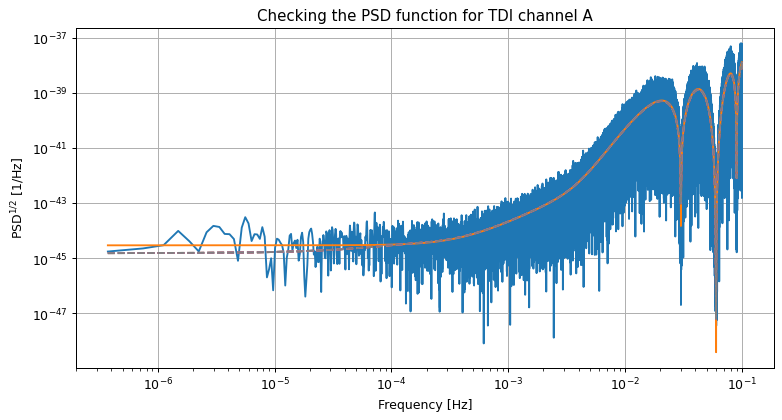

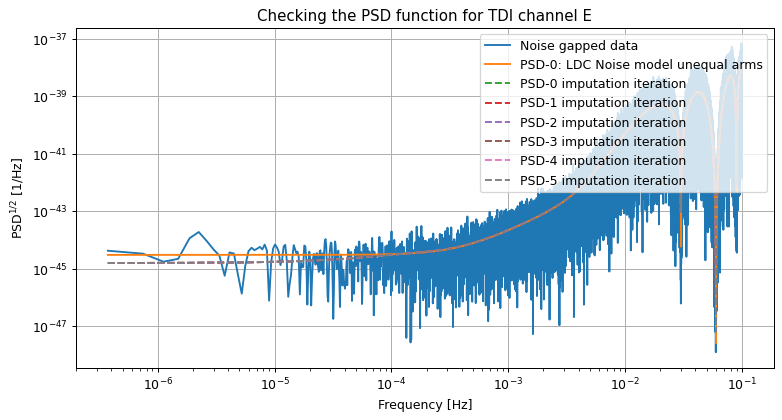

In [36]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 6


    
# Observation time
t_obs = ndata / fs
# Lower frequency for the PSD estimation
fmin = 1 / t_obs * 1.05
# Upper frequency
fmax = fs/2
# Instantiate PSD estimator class
for tdi in names:
    psd_cls.append(LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
# perform data imputation

## initialize imputation
for tdi in names:
    y_masked = datang[tdi]
    s = np.zeros(len(mask))  # for residual 'signal' is zero
    # initialize PSD-0 to the LDC unequal arm noise model
    psd_cls = LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi)
    # instantiate imputation class
    print('Instantiate imputation class for tdi channel '+tdi)
    imp_cls.append(datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=100, nb=100))
    print('Compute PSD dependent terms')
    imp_cls[names.index(tdi)].compute_offline() 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise gapped data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="PSD-0: LDC Noise model unequal arms")
    ax.grid()
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(mask*(y_masked - s)).T) # (ymasked - s)
    print('\t\t Impute missing data for iteration 0')
    y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
    # Update the data residuals
    print('\t Update data residuals')
    y_res = y_rec - s
    datang_rec[tdi] = y_res
    for i in range(n_iter):
        print('Imputation iteration '+str(i))
        t1 = time.time()
        # Do update PSD
        print('\t FT data residuals')
        fd = makeFDdata(datang_rec)
        #ModelPSD=ModelFDDataPSD
        ModelPSD = fillgaps.ModelFDDataPSD
        print('\t Instantiate PSD estimator')        
        psdmod = ModelPSD(data=fd, 
                          channel=tdi, 
                          fit_type=None,#'log_spline',fit_dof=14,
                          smooth_df=4e-4,
                          fmin=psddatang['f'][0])
        print('\t Update PSD')
        imp_cls[names.index(tdi)].update_psd(psdmod)
        
        ax.loglog(psdmod.f[psdmod.f>0], (psdmod.psd_fn(psdmod.f[psdmod.f>0])), ls='--', label='PSD-'+str(i)+' imputation iteration')
        # Re-compute of PSD-dependent terms
        print('\t Recompute PSD dependent terms')
        imp_cls[names.index(tdi)].compute_offline()
        # Imputation of missing data by randomly drawing from their conditional distribution
        print('\t\t Impute missing data')
        y_rec = imp_cls[names.index(tdi)].impute(y_masked, draw=True)
        # Update the data residuals
        print('\t Update data residuals')
        y_res = y_rec - s
        datang_rec[tdi] = y_res
        print(y_res[spritzmask['starts'][0]-1:spritzmask['ends'][0]+1:])
        t2 = time.time()
#         print("The imputation /  PSD estimation for combination " + names[tdi] + " in iteration "+ str(i) +" took " + str(t2-t1))

ax.legend(loc='upper right')
ax.grid()

ax.grid()

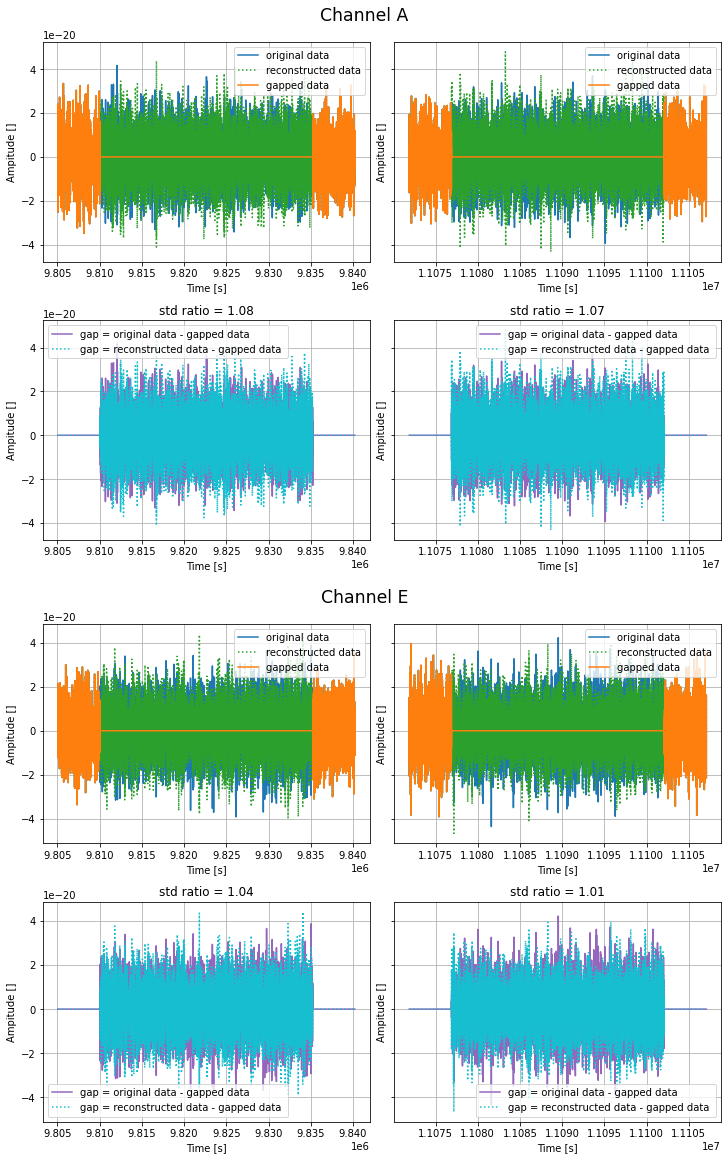

In [37]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=1000)

In [38]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

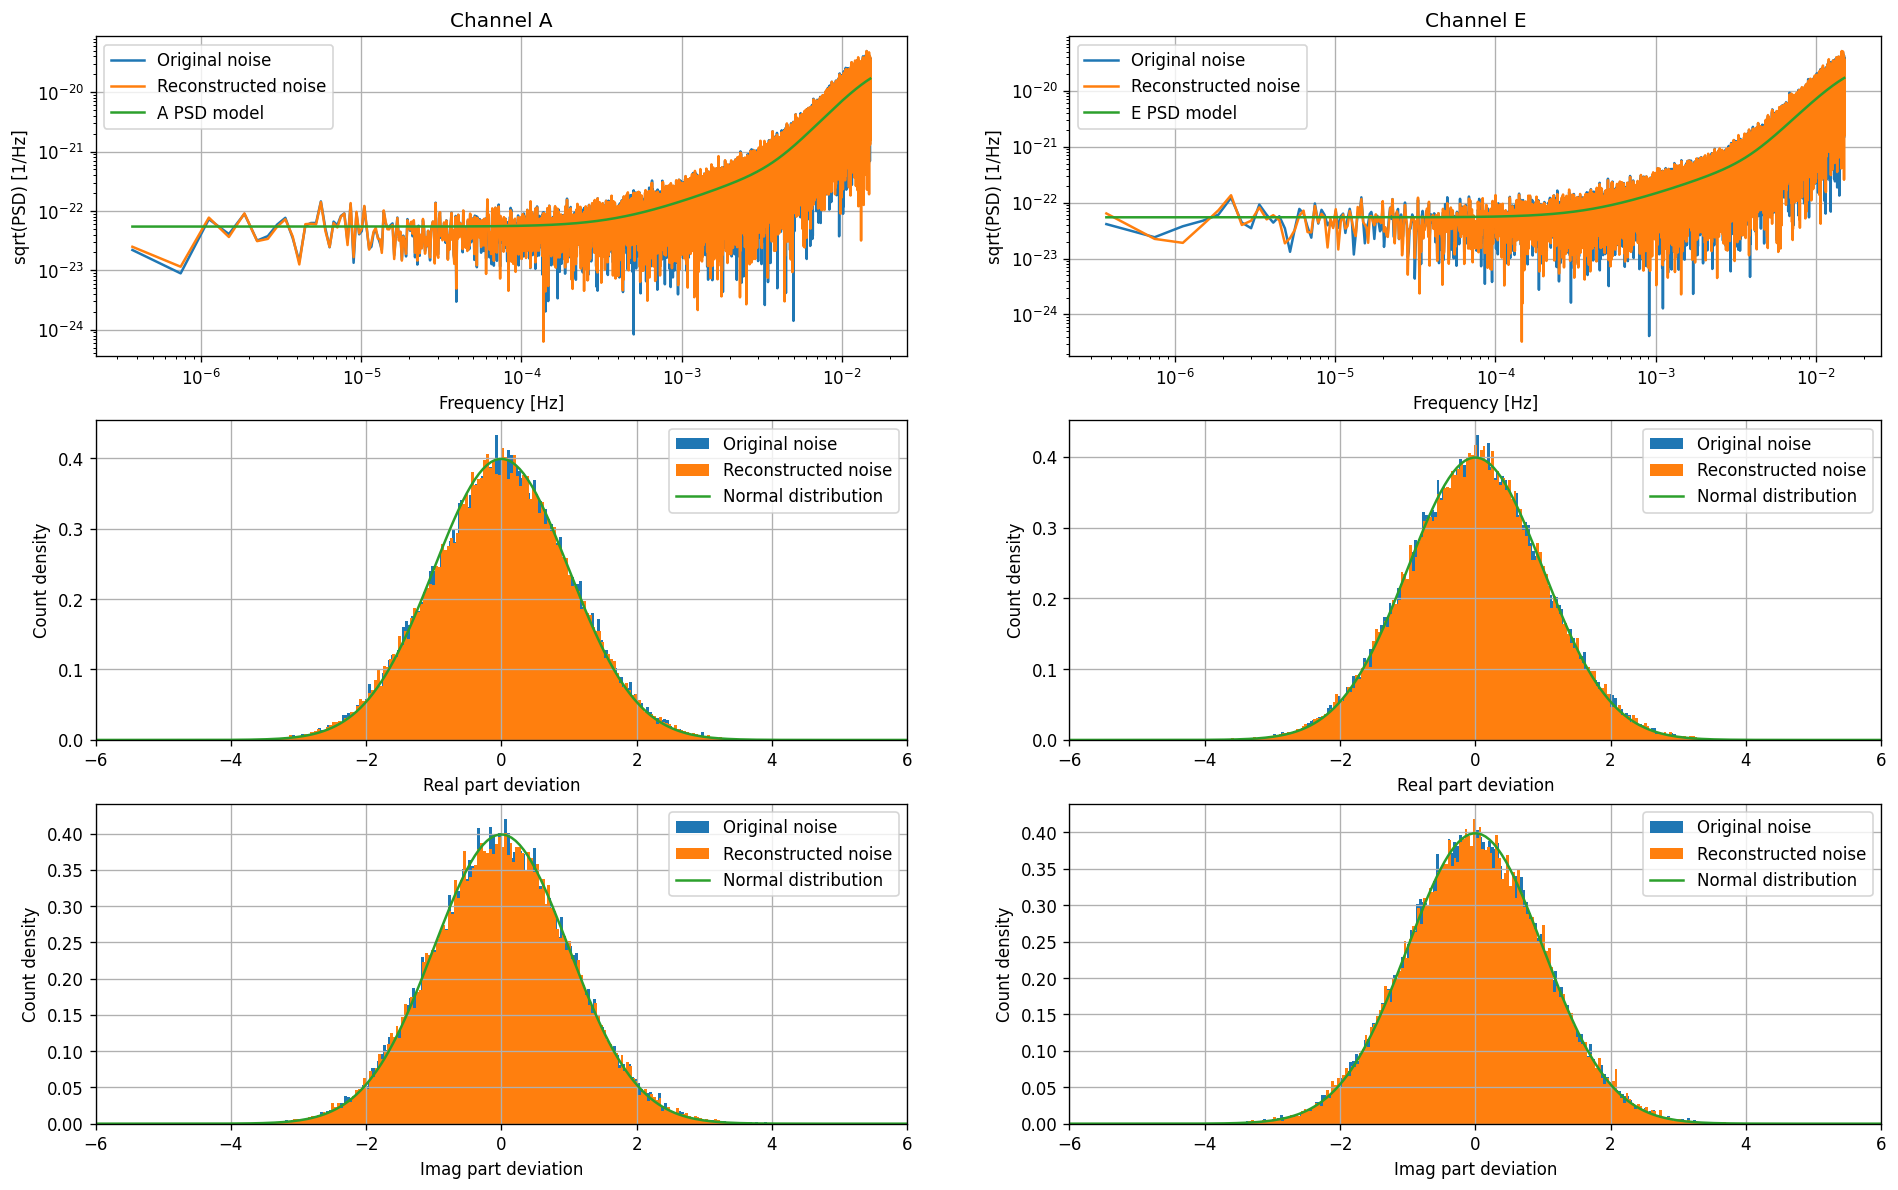

In [39]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                noise_models = [S.get(key) for key in ['A','E']],
                                fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

##### 4.1.7.b PSD estimated with `fit_type='poly_fit`

Instantiate imputation class for tdi channel A
Compute PSD dependent terms
Computation of autocovariance + PSD took 6.654504060745239
Imputation iteration 0
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.2398531436920166
		 Impute missing data
	 Update data residuals
Imputation iteration 1
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD
	 Recompute PSD dependent terms


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


Computation of autocovariance + PSD took 0.22615909576416016
		 Impute missing data
	 Update data residuals
Imputation iteration 2
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.23237204551696777
		 Impute missing data
	 Update data residuals
Imputation iteration 3
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD
	 Recompute PSD dependent terms


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


Computation of autocovariance + PSD took 0.2333228588104248
		 Impute missing data
	 Update data residuals
Imputation iteration 4
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.22936701774597168
		 Impute missing data
	 Update data residuals
Imputation iteration 5
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.23808526992797852
		 Impute missing data
	 Update data residuals
Imputation iteration 6
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.21789789199829102
		 Impute missing data
	 Update data residuals
Imputation iteration 7
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.2336738109588623
		 Impute missing data
	 Update data residuals
Imputation iteration 8
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.23694705963134766
		 Impute missing data
	 Update data residuals
Imputation iteration 9
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.24823927879333496
		 Impute missing data
	 Update data residuals
Instantiate imputation class for tdi channel E
Compute PSD dependent terms
Computation of autocovariance + PSD took 8.624002933502197
Imputation iteration 0
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.2319328784942627
		 Impute missing data
	 Update data residuals
Imputation iteration 1
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD
	 Recompute PSD dependent terms


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


Computation of autocovariance + PSD took 0.22978997230529785
		 Impute missing data
	 Update data residuals
Imputation iteration 2
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.22170710563659668
		 Impute missing data
	 Update data residuals
Imputation iteration 3
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD
	 Recompute PSD dependent terms


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


Computation of autocovariance + PSD took 0.22151398658752441
		 Impute missing data
	 Update data residuals
Imputation iteration 4
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD
	 Recompute PSD dependent terms


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


Computation of autocovariance + PSD took 0.22496819496154785
		 Impute missing data
	 Update data residuals
Imputation iteration 5
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.22614097595214844
		 Impute missing data
	 Update data residuals
Imputation iteration 6
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD
	 Recompute PSD dependent terms


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


Computation of autocovariance + PSD took 0.23030924797058105
		 Impute missing data
	 Update data residuals
Imputation iteration 7
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD
	 Recompute PSD dependent terms


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


Computation of autocovariance + PSD took 0.2234959602355957
		 Impute missing data
	 Update data residuals
Imputation iteration 8
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD
	 Recompute PSD dependent terms


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


Computation of autocovariance + PSD took 0.22855496406555176
		 Impute missing data
	 Update data residuals
Imputation iteration 9
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
	 Update PSD


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/387934704.py:59: RankWarning: Polyfit may be poorly conditioned
  psdmod = ModelPSD(data=fd,


	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.23167991638183594
		 Impute missing data
	 Update data residuals


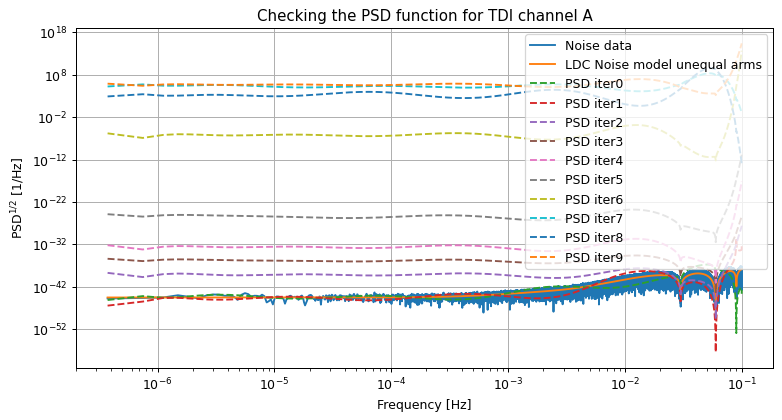

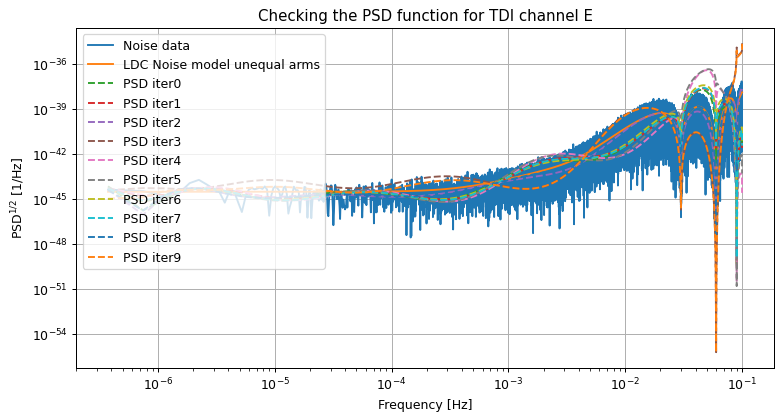

In [40]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10


    
# Observation time
t_obs = ndata / fs
# Lower frequency for the PSD estimation
fmin = 1 / t_obs * 1.05
# Upper frequency
fmax = fs/2
# Instantiate PSD estimator class
for tdi in names:
    psd_cls.append(LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
# perform data imputation

## initialize imputation

for tdi in names:
    y_masked = datang[tdi]
    s = np.zeros(len(mask))  # for residual 'signal' is zero
    # initialize PSD-0 to the LDC unequal arm noise model
    psd_cls = LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi)
    # instantiate imputation class
    print('Instantiate imputation class for tdi channel '+tdi)
    imp_cls.append(datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=100, nb=100))
    print('Compute PSD dependent terms')
    imp_cls[names.index(tdi)].compute_offline() 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(mask*(y_masked - s)).T) # (ymasked - s)
    datang_rec[tdi] = y_res
    for i in range(n_iter):
        print('Imputation iteration '+str(i))
        t1 = time.time()
        # Do update PSD
        print('\t FT data residuals')
        fd = makeFDdata(datang_rec)
        #ModelPSD=ModelFDDataPSD
        ModelPSD = fillgaps.ModelFDDataPSD
        print('\t Instantiate PSD estimator')        
        psdmod = ModelPSD(data=fd, 
                          channel=tdi, 
                          fit_type='log_poly',
                          fit_dof=10,
                          smooth_df=4e-4,
                          fmin=psddatang['f'][0])

        print('\t Update PSD')
        imp_cls[names.index(tdi)].update_psd(psdmod)
        
        ax.loglog(psdmod.f[psdmod.f>0], (psdmod.psd_fn(psdmod.f[psdmod.f>0])), ls='--', label="PSD iter"+str(i))
        ax.legend(loc='upper right')
        # Re-compute of PSD-dependent terms
        print('\t Recompute PSD dependent terms')
        imp_cls[names.index(tdi)].compute_offline()
        # Imputation of missing data by randomly drawing from their conditional distribution
        print('\t\t Impute missing data')
        y_rec = imp_cls[names.index(tdi)].impute(y_masked, draw=True)
        # Update the data residuals
        print('\t Update data residuals')
        y_res = y_rec - s
        datang_rec[tdi] = y_res
#         print(y_res[spritzmask['starts'][0]-1:spritzmask['ends'][0]+1:])
        t2 = time.time()
#         print("The imputation /  PSD estimation for combination " + names[tdi] + " in iteration "+ str(i) +" took " + str(t2-t1))

ax.legend(loc='best')
ax.grid()

ax.grid()

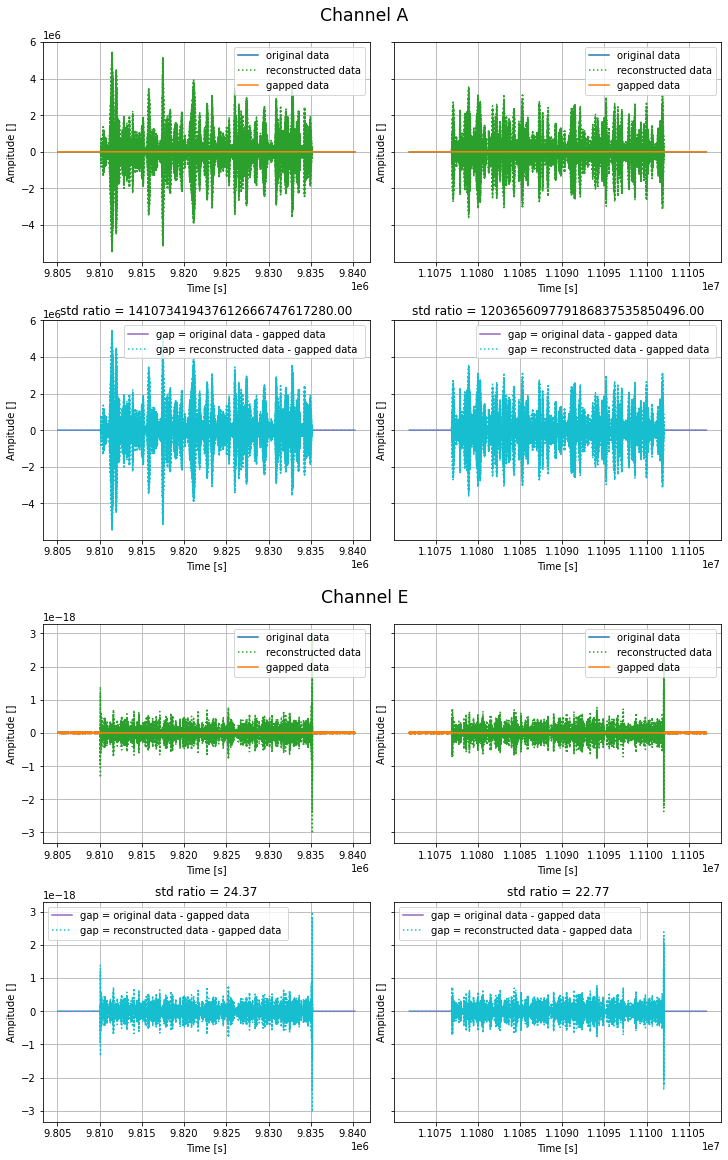

In [41]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=1000)

In [42]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

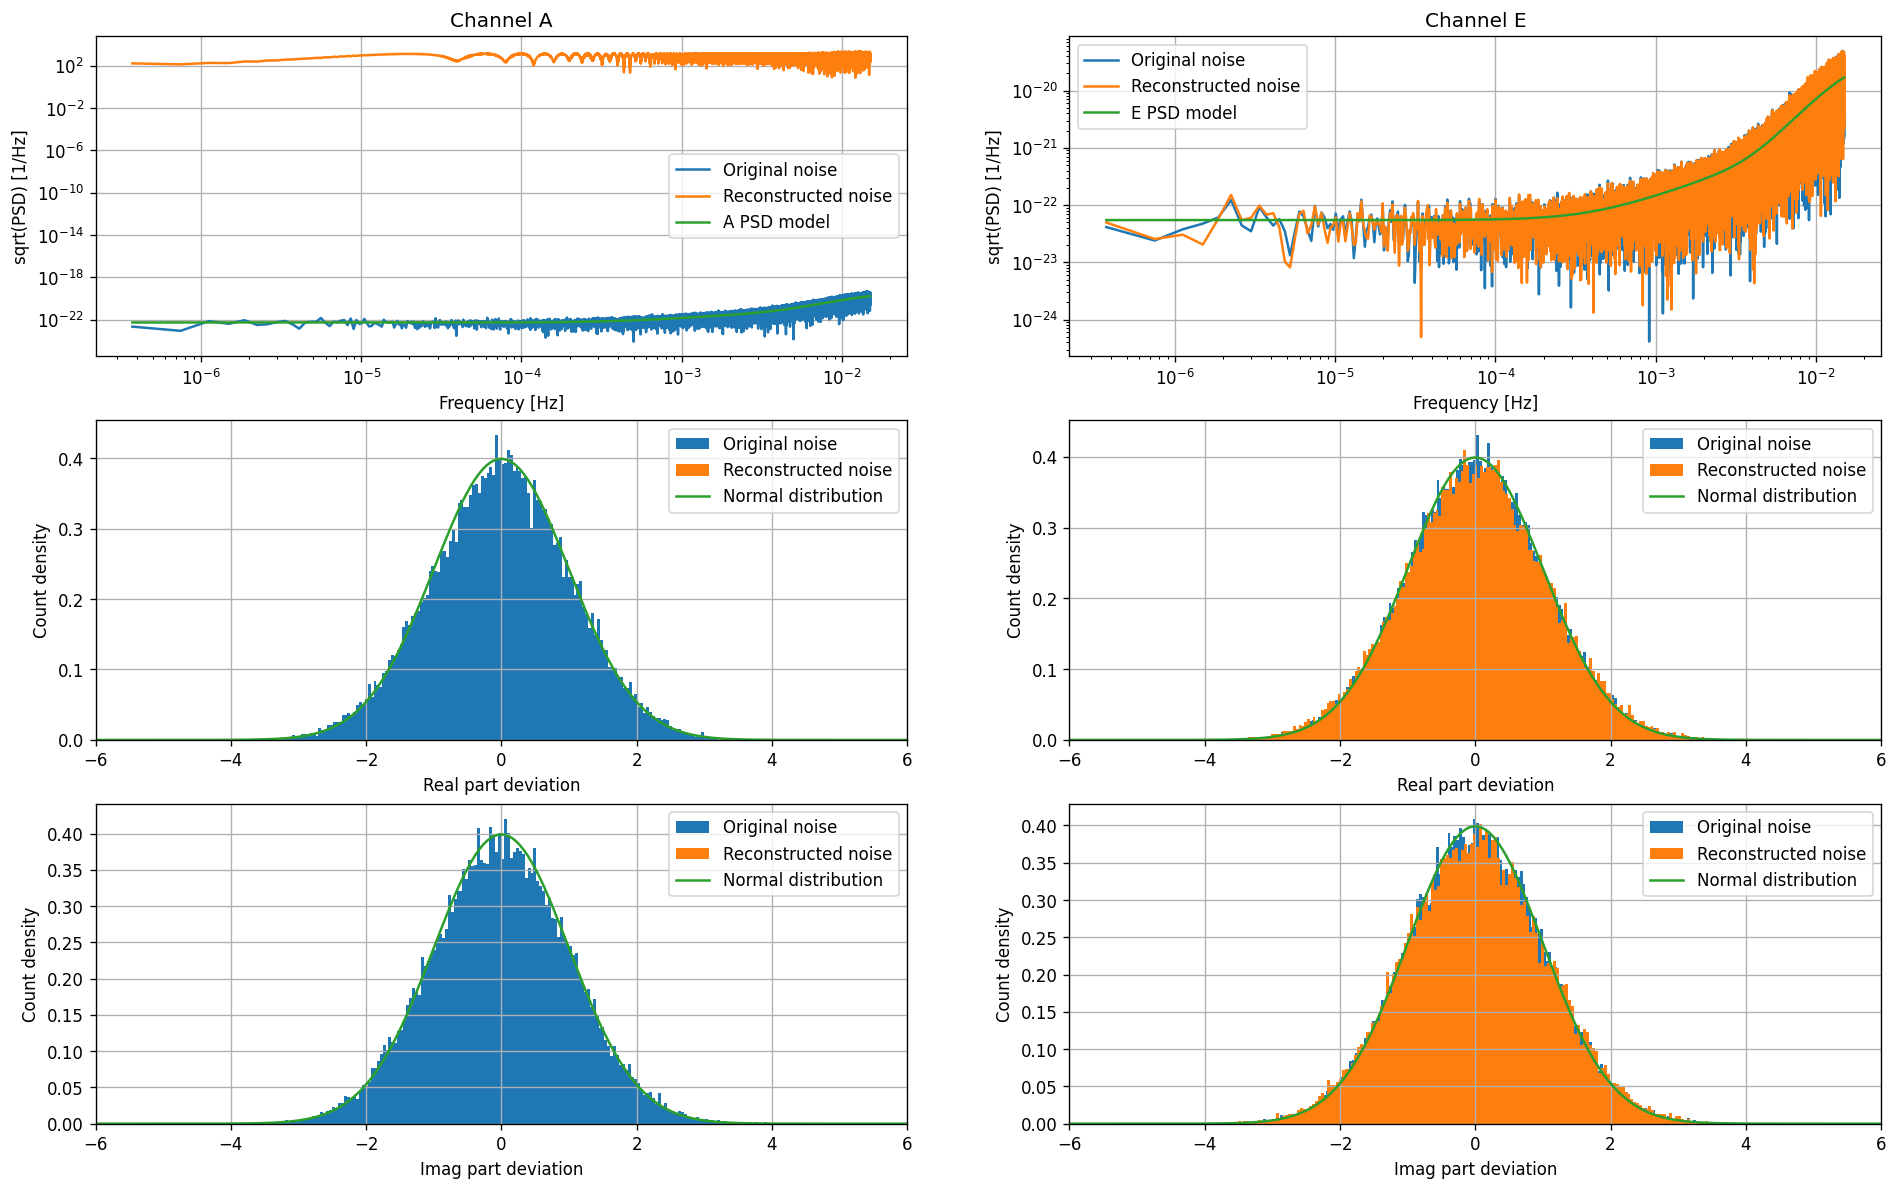

In [43]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                noise_models = [S.get(key) for key in ['A','E']],
                                fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

##### 4.1.7.c PSD estimated with `fit_type='log_spline` and `fit_dof=6`

Instantiate imputation class for tdi channel A
Compute PSD dependent terms
Computation of autocovariance + PSD took 6.5696892738342285
		 Impute missing data for iteration 0
	 Update data residuals
Imputation iteration 0
	 FT data residuals
	 Instantiate PSD estimator
Fitting on log-scale
3.734269390193809e-07 < f <  0.1 fmin/fmax= 3.7342693901938084e-07 None
Finding knots in  3.734269390193809e-07 < x < 0.1
alpha 0.8160385994727243
knots before trim: [3.73426939e-07 3.73426939e-06 2.44480511e-05 1.13282608e-04
 3.95893932e-04 1.09907405e-03 2.52870244e-03 4.99112271e-03
 8.69310388e-03 1.36716551e-02 1.97829934e-02 2.67449914e-02
 3.42060629e-02 4.18124375e-02 4.92567789e-02 5.63035451e-02
 6.27946846e-02 6.86424256e-02 7.38156793e-02 7.83248431e-02
 8.22078467e-02 8.55187402e-02 8.83191220e-02 9.06721547e-02
 9.26386973e-02 9.42750339e-02 9.56317417e-02 9.67533220e-02
 9.76783147e-02 9.84396932e-02 9.90654029e-02 9.95789521e-02]
32
30 knots before checking
30 knots after ensuring con

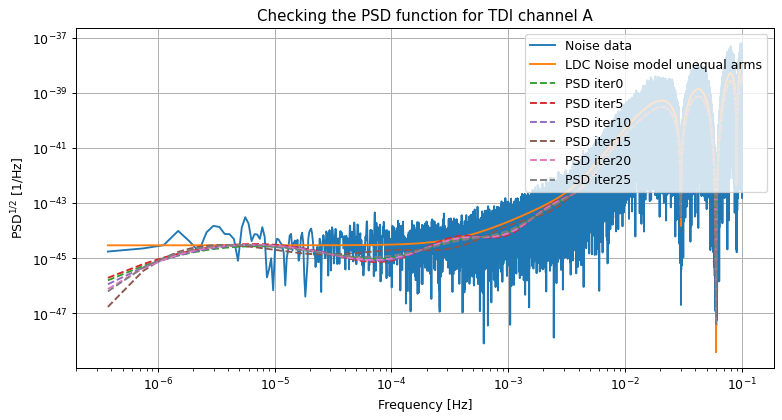

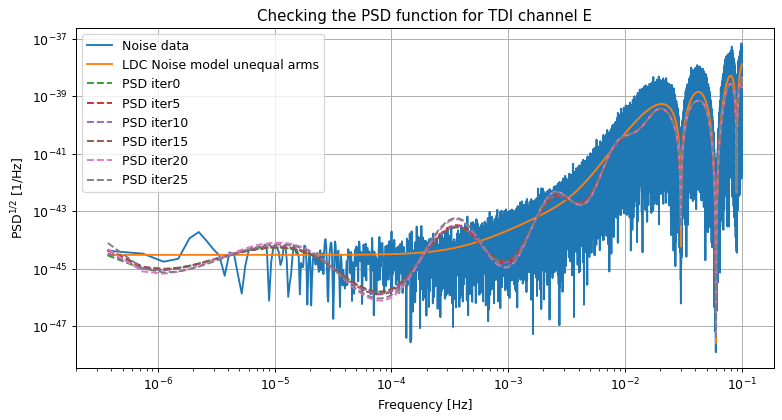

In [44]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 30


    
# Observation time
t_obs = ndata / fs
# Lower frequency for the PSD estimation
fmin = 1 / t_obs * 1.05
# Upper frequency
fmax = fs/2
# Instantiate PSD estimator class
for tdi in names:
    psd_cls.append(LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
# perform data imputation

## initialize imputation

for tdi in names:
    y_masked = datang[tdi]
    s = np.zeros(len(mask))  # for residual 'signal' is zero
    # initialize PSD-0 to the LDC unequal arm noise model
    psd_cls = LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi)
    # instantiate imputation class
    print('Instantiate imputation class for tdi channel '+tdi)
    imp_cls.append(datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=100, nb=100))
    print('Compute PSD dependent terms')
    imp_cls[names.index(tdi)].compute_offline() 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(mask*(y_masked - s)).T) # (ymasked - s)
    
    print('\t\t Impute missing data for iteration 0')
    y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
    # Update the data residuals
    print('\t Update data residuals')
    y_res = y_rec - s
    datang_rec[tdi] = y_res
    for i in range(n_iter):
        print('Imputation iteration '+str(i))
        t1 = time.time()
        # Do update PSD
        print('\t FT data residuals')
        fd = makeFDdata(datang_rec)
        #ModelPSD=ModelFDDataPSD
        ModelPSD = fillgaps.ModelFDDataPSD
        print('\t Instantiate PSD estimator')        
        psdmod = ModelPSD(data=fd, 
                          channel=tdi, 
                          fit_type='log_spline',
                          fit_dof=30,
                          smooth_df=4e-4,
                          fmin=psddatang['f'][0])

        print('\t Update PSD')
        imp_cls[names.index(tdi)].update_psd(psdmod)
        if (i % 5)==0:
            ax.loglog(psdmod.f[psdmod.f>0], (psdmod.psd_fn(psdmod.f[psdmod.f>0])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper right')
        # Re-compute of PSD-dependent terms
        print('\t Recompute PSD dependent terms')
        imp_cls[names.index(tdi)].compute_offline()
        # Imputation of missing data by randomly drawing from their conditional distribution
        print('\t\t Impute missing data')
        y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
        # Update the data residuals
        print('\t Update data residuals')
        y_res = y_rec - s
        datang_rec[tdi] = y_res
#         print(y_res[spritzmask['starts'][0]-1:spritzmask['ends'][0]+1:])
        t2 = time.time()
        print("The imputation /  PSD estimation for combination " + tdi + " in iteration "+ str(i) +" took " + str(t2-t1))

ax.legend(loc='best')
ax.grid()

ax.grid()

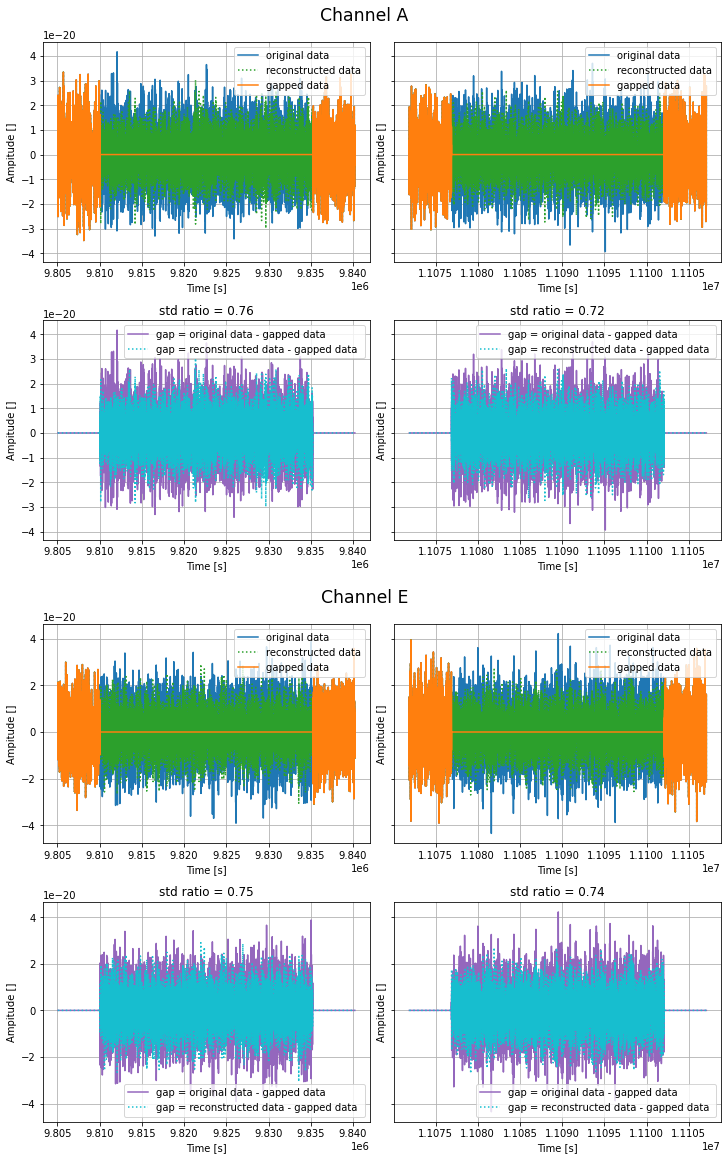

In [45]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=1000)

In [46]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

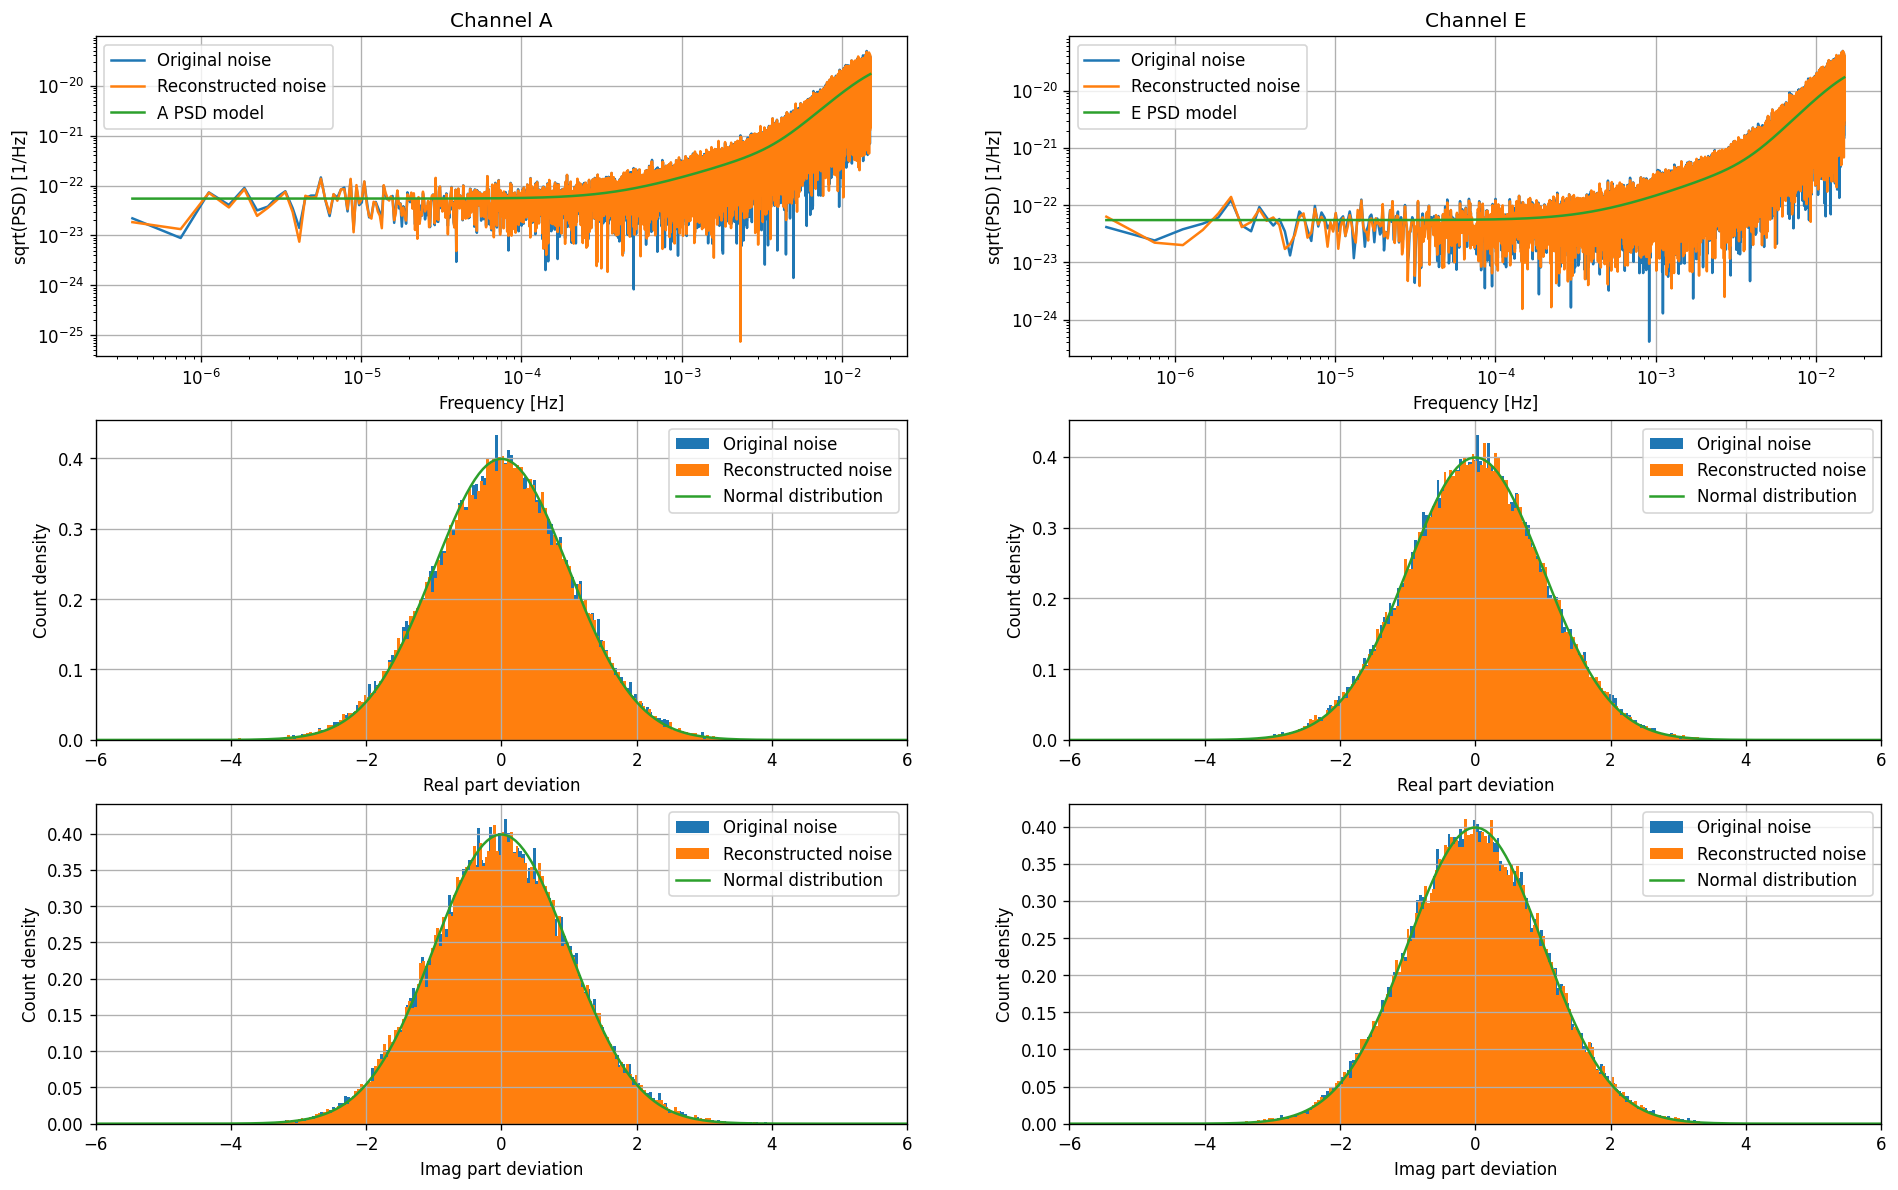

In [47]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                noise_models = [S.get(key) for key in ['A','E']],
                                fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

Instantiate imputation class for tdi channel A
Compute PSD dependent terms
Computation of autocovariance + PSD took 6.801100015640259
		 Impute missing data for iteration 0
	 Update data residuals
Imputation iteration 0
	 FT data residuals
	 Instantiate PSD estimator
	 Update PSD
	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.20529508590698242
		 Impute missing data
	 Update data residuals
The imputation /  PSD estimation for combination A in iteration 0 took 0.5158360004425049
Instantiate imputation class for tdi channel E
Compute PSD dependent terms
Computation of autocovariance + PSD took 6.7287211418151855
		 Impute missing data for iteration 0
	 Update data residuals
Imputation iteration 0
	 FT data residuals
	 Instantiate PSD estimator
	 Update PSD
	 Recompute PSD dependent terms
Computation of autocovariance + PSD took 0.21521377563476562
		 Impute missing data
	 Update data residuals
The imputation /  PSD estimation for combination E in iteration 0 t

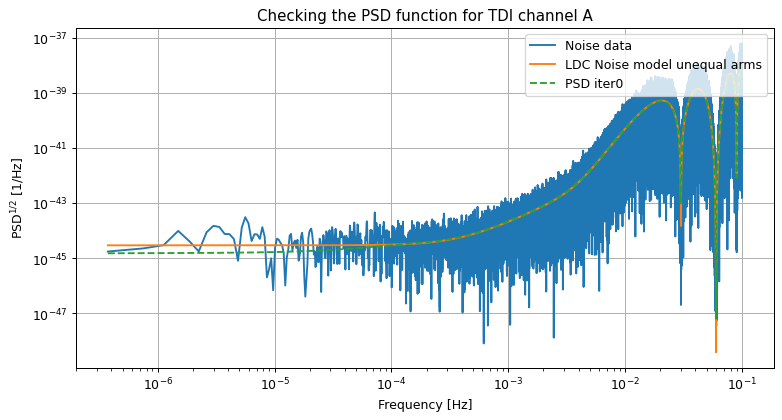

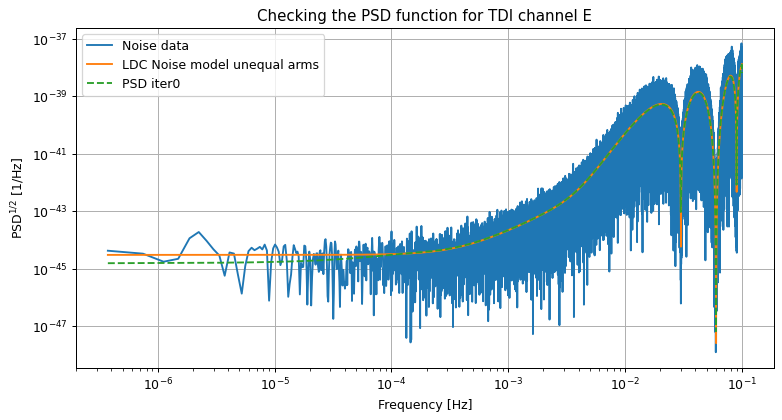

In [48]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 1


    
# Observation time
t_obs = ndata / fs
# Lower frequency for the PSD estimation
fmin = 1 / t_obs * 1.05
# Upper frequency
fmax = fs/2
# Instantiate PSD estimator class
for tdi in names:
    psd_cls.append(LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi))#, fmax = 15e-3))
# perform data imputation

## initialize imputation

for tdi in names:
    y_masked = datang[tdi]
    s = np.zeros(len(mask))  # for residual 'signal' is zero
    # initialize PSD-0 to the LDC unequal arm noise model
    psd_cls = LDCModelPSD0(ndata, fs, noise_model = 'spritz', channel = tdi)
    # instantiate imputation class
    print('Instantiate imputation class for tdi channel '+tdi)
    imp_cls.append(datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=100, nb=100))
    print('Compute PSD dependent terms')
    imp_cls[names.index(tdi)].compute_offline() 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(mask*(y_masked - s)).T) # (ymasked - s)
    
    print('\t\t Impute missing data for iteration 0')
    y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
    # Update the data residuals
    print('\t Update data residuals')
    y_res = y_rec - s
    datang_rec[tdi] = y_res
    for i in range(n_iter):
        print('Imputation iteration '+str(i))
        t1 = time.time()
        # Do update PSD
        print('\t FT data residuals')
        fd = makeFDdata(datan)
        #ModelPSD=ModelFDDataPSD
        ModelPSD = fillgaps.ModelFDDataPSD
        print('\t Instantiate PSD estimator')        
        psdmod = ModelPSD(data=fd, 
                          channel=tdi, 
                          fit_type=None, 
                          smooth_df=4e-4,
                          fmin=1e-6)
#         psdmod = ModelPSD(data=fd, 
#                           channel=tdi, 
#                           fit_type='log_spline',
#                           fit_dof=20,
#                           smooth_df=4e-4,
#                           fmin=0.8e-5,
#                           fmax= 4e-2)

        print('\t Update PSD')
        imp_cls[names.index(tdi)].update_psd(psdmod)
        
        ax.loglog(psdmod.f[psdmod.f>0], (psdmod.psd_fn(psdmod.f[psdmod.f>0])), ls='--', label="PSD iter"+str(i))
        ax.legend(loc='upper right')
        # Re-compute of PSD-dependent terms
        print('\t Recompute PSD dependent terms')
        imp_cls[names.index(tdi)].compute_offline()
        # Imputation of missing data by randomly drawing from their conditional distribution
        print('\t\t Impute missing data')
        y_rec = imp_cls[names.index(tdi)].impute(y_res, draw=True)
        # Update the data residuals
        print('\t Update data residuals')
        y_res = y_rec - s
        datang_rec[tdi] = y_res
#         print(y_res[spritzmask['starts'][0]-1:spritzmask['ends'][0]+1:])
        t2 = time.time()
        print("The imputation /  PSD estimation for combination " + tdi + " in iteration "+ str(i) +" took " + str(t2-t1))

ax.legend(loc='best')
ax.grid()

ax.grid()

In [49]:
psddatang['f'][1]

7.468538780387617e-07

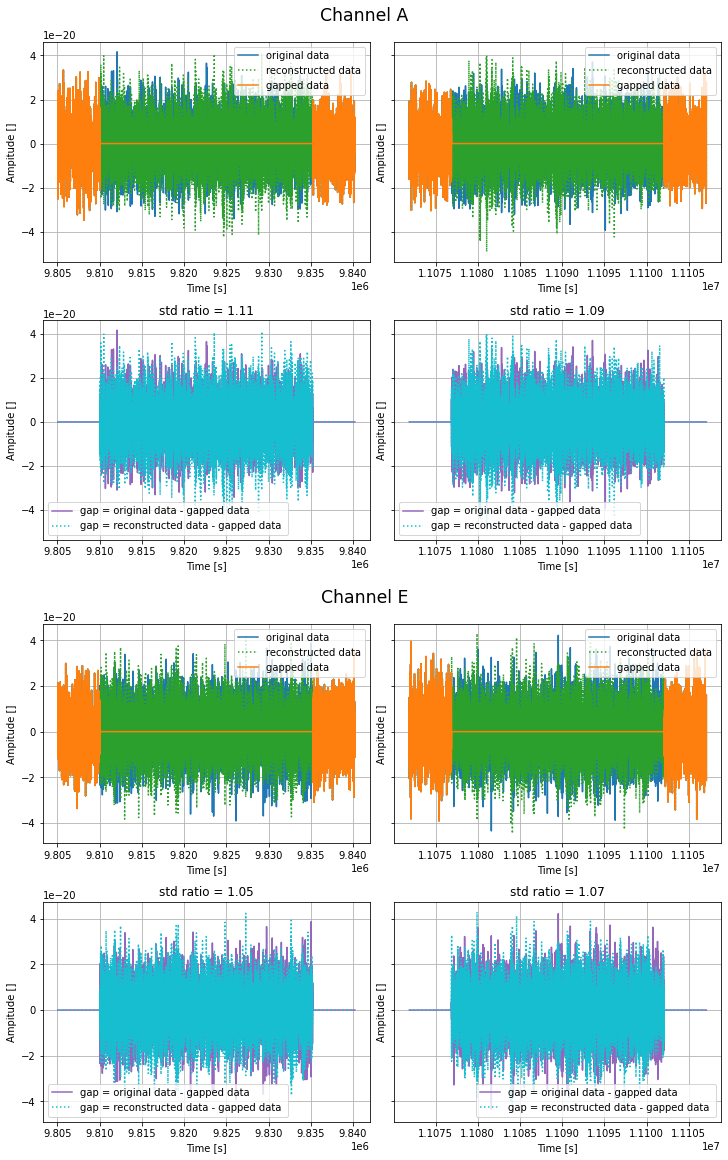

In [50]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=1000)

In [51]:
fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec) 

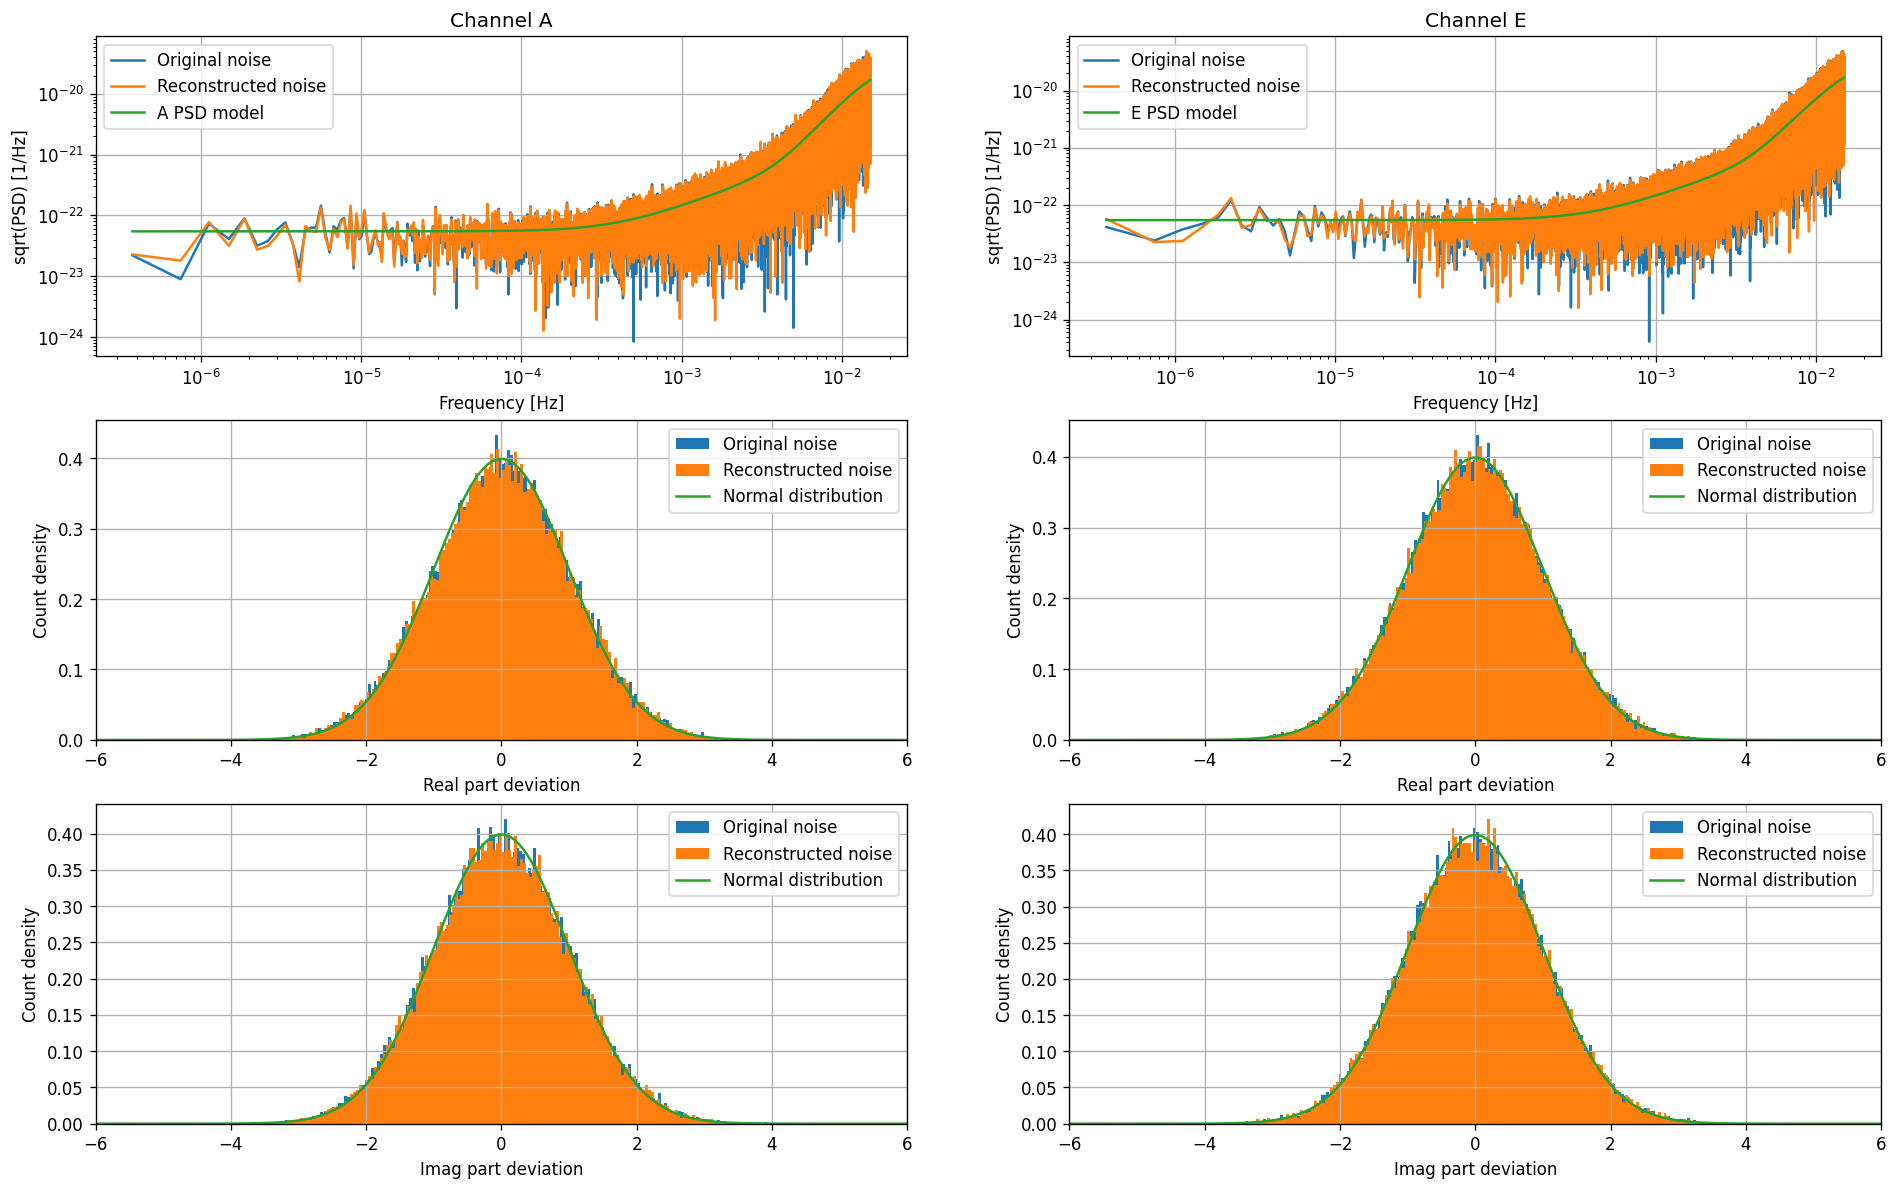

In [52]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                noise_models = [S.get(key) for key in ['A','E']],
                                fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

### John's code snippet

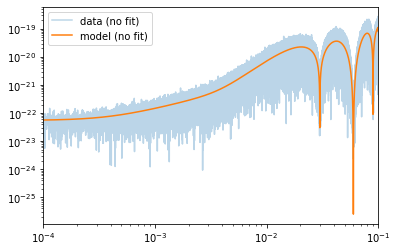

log_poly
Fitting on log-scale
x [-11.5047066  -11.46833895 -11.43324763 -11.39934608 -11.36655626]
y [0.96041905 0.87757509 0.9724236  1.00202773 1.0439763 ]
fit [0.96041905 0.87757509 0.9724236  1.00202773 1.0439763 ]


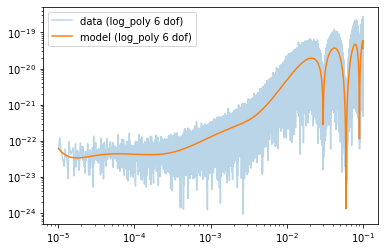

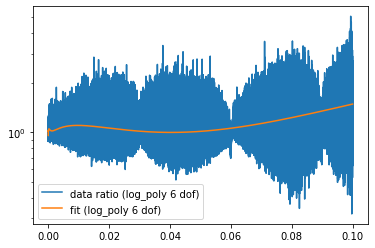

Fitting on log-scale


/var/folders/5g/hyf4_fxs537fx34c_80ycrq80000gp/T/ipykernel_12759/3349549053.py:27: RankWarning: Polyfit may be poorly conditioned
  psdmod=ModelPSD(fd,'A',fit_type='log_poly',fit_dof=14,smooth_df=4e-4,fmin=1e-5)


x [-11.5047066  -11.46833895 -11.43324763 -11.39934608 -11.36655626]
y [0.96041905 0.87757509 0.9724236  1.00202773 1.0439763 ]
fit [0.96041905 0.87757509 0.9724236  1.00202773 1.0439763 ]


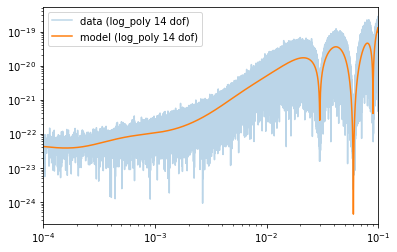

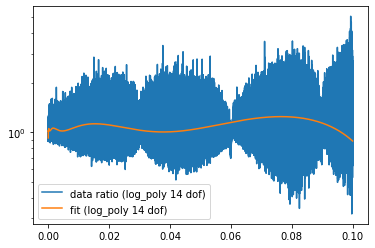

log_spline
Fitting on log-scale
1.0082527353523284e-05 < f <  0.1 fmin/fmax= 1e-05 None
Finding knots in  1.0082527353523284e-05 < x < 0.1
alpha 0.7524170909978375
knots before trim: [1.00825274e-05 1.00825274e-04 5.70146549e-04 2.09951015e-03
 5.59867141e-03 1.17108881e-02 2.04053082e-02 3.09878214e-02
 4.24341526e-02 5.37574790e-02 6.42287848e-02 7.34318776e-02
 8.12159622e-02 8.76122289e-02 9.27548888e-02 9.68223782e-02]
16
14 knots before checking
14 knots after ensuring condition.
knots [0.00010083 0.00057015 0.00209951 0.00559867 0.01171089 0.02040531
 0.03098782 0.04243415 0.05375748 0.06422878 0.07343188 0.08121596
 0.08761223 0.09275489]
x [-11.5047066  -11.46833895 -11.43324763 -11.39934608 -11.36655626]
y [0.96041905 0.87757509 0.9724236  1.00202773 1.0439763 ]
fit [0.96041905 0.87757509 0.9724236  1.00202773 1.0439763 ]


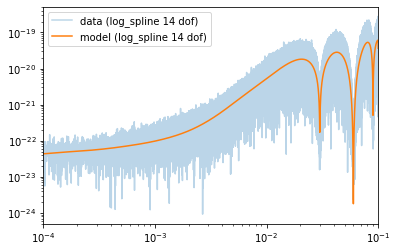

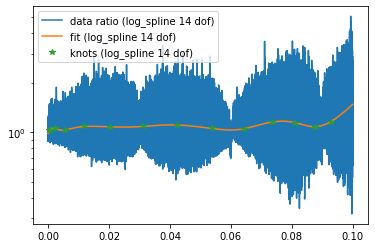

Fitting on log-scale
1.0082527353523284e-05 < f <  0.1 fmin/fmax= 1e-05 None
Finding knots in  1.0082527353523284e-05 < x < 0.1
alpha 0.7502260314713403
knots before trim: [1.00825274e-05 1.00825274e-04 5.67277346e-04 2.07316820e-03
 5.48139478e-03 1.13678657e-02 1.96490440e-02 2.96238850e-02
 4.03095319e-02 5.07881387e-02 6.04019400e-02 6.87914316e-02
 7.58419882e-02 8.16020012e-02 8.62087444e-02 8.98347976e-02
 9.26549431e-02 9.48286631e-02 9.64928602e-02 9.77605309e-02
 9.87224925e-02 9.94503905e-02]
22
20 knots before checking
20 knots after ensuring condition.
knots [0.00010083 0.00056728 0.00207317 0.00548139 0.01136787 0.01964904
 0.02962388 0.04030953 0.05078814 0.06040194 0.06879143 0.07584199
 0.081602   0.08620874 0.0898348  0.09265494 0.09482866 0.09649286
 0.09776053 0.09872249]
x [-11.5047066  -11.46833895 -11.43324763 -11.39934608 -11.36655626]
y [0.96041905 0.87757509 0.9724236  1.00202773 1.0439763 ]
fit [0.96041905 0.87757509 0.9724236  1.00202773 1.0439763 ]


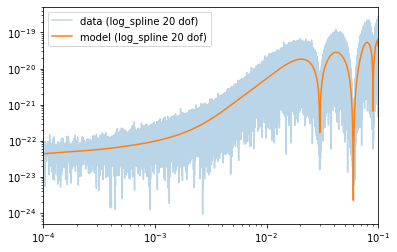

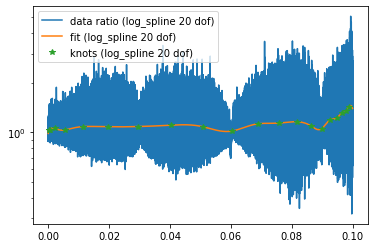

spline no analytic model
Fitting on log-scale
1.0082527353523284e-05 < f <  0.1 fmin/fmax= 1e-05 None
Finding knots in  1.0082527353523284e-05 < x < 0.1
alpha 0.7498016363631966
knots before trim: [1.00825274e-05 1.00825274e-04 5.66723270e-04 2.06810955e-03
 5.45900999e-03 1.13027867e-02 1.95063750e-02 2.93678962e-02
 3.99125786e-02 5.02355396e-02 5.96921495e-02 6.79331838e-02
 7.48504458e-02 8.04952687e-02 8.50053115e-02 8.85519539e-02
 9.13079708e-02 9.34305612e-02 9.50543897e-02 9.62904261e-02
 9.72277406e-02 9.79365211e-02 9.84713533e-02 9.88742866e-02
 9.91774878e-02 9.94054383e-02 9.95766996e-02 9.97053052e-02
 9.98018428e-02 9.98742881e-02 9.99286423e-02 9.99694165e-02]
32
30 knots before checking
30 knots after ensuring condition.
knots [0.00010083 0.00056672 0.00206811 0.00545901 0.01130279 0.01950638
 0.0293679  0.03991258 0.05023554 0.05969215 0.06793318 0.07485045
 0.08049527 0.08500531 0.08855195 0.09130797 0.09343056 0.09505439
 0.09629043 0.09722774 0.09793652 0.09847135

(0.0001, 0.1)

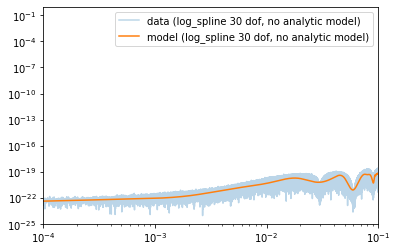

In [53]:
import importlib
import bayesdawn.connect.fillgaps as fillgaps
importlib.reload(fillgaps)
fd=fillgaps.makeFDdata(build_orthogonal_tdi(tdidata['noise']))
#ModelPSD=ModelFDDataPSD
ModelPSD=fillgaps.ModelFDDataPSD
show_fit=True
lims=(None,None)
#lims=(0.029,0.062)
lims=(1e-4,.1)
#psdmod=ModelPSD(fd,'A',fit_type=None,fmin=1e-5)
#psdmod.plot()
#psdmod=ModelPSD(fd,'A',fit_type=None,smooth_df=4e-6,fmin=1e-5)
#psdmod.plot()
psdmod=ModelPSD(fd,'A',fit_type=None,smooth_df=4e-5,fmin=1e-5)
psdmod.plot()
plt.xlim(*lims)
plt.show()
#print('poly')
#psdmod=ModelPSD(fd,'A',fit_type='poly',fit_dof=4,smooth_df=4e-4,fmin=1e-5)
#psdmod.plot(show_fit=show_fit)
print('log_poly')
psdmod=ModelPSD(fd,'A',fit_type='log_poly',fit_dof=6,smooth_df=4e-4,fmin=1e-5)
psdmod.plot(show_fit=show_fit,tag='log_poly 6 dof')
plt.xlim(*lims)

psdmod=ModelPSD(fd,'A',fit_type='log_poly',fit_dof=14,smooth_df=4e-4,fmin=1e-5)
psdmod.plot(show_fit=show_fit,tag='log_poly 14 dof')
plt.xlim(*lims)

if not show_fit:plt.show()
print('log_spline')
psdmod=ModelPSD(fd,'A',fit_type='log_spline',fit_dof=14,smooth_df=4e-4,fmin=1e-5)
psdmod.plot(show_fit=show_fit,tag='log_spline 14 dof')
plt.xlim(*lims)
psdmod=ModelPSD(fd,'A',fit_type='log_spline',fit_dof=20,smooth_df=4e-4,fmin=1e-5)
psdmod.plot(show_fit=show_fit,tag='log_spline 20 dof')
plt.xlim(*lims)
plt.ylim(1e-25,None)

if False:
    print('spline')
    psdmod=ModelPSD(fd,'A',fit_type='spline',fit_dof=30,smooth_df=4e-4,fmin=1e-5)
    psdmod.plot(show_fit=show_fit,tag='spline 30 dof')
    plt.xlim(*lims)
    psdmod=ModelPSD(fd,'A',fit_type='spline',fit_dof=60,smooth_df=4e-4,fmin=1e-5)
    psdmod.plot(show_fit=show_fit,tag='spline 60 dof')
    plt.xlim(*lims)
    plt.ylim(1e-25,None)
    plt.show()
    
print('spline no analytic model')
psdmod=ModelPSD(fd,'A',fit_type='log_spline',noise_model=None,fit_dof=30,fmin=1e-5)
psdmod.plot(show_fit=show_fit,tag='log_spline 30 dof, no analytic model')
plt.xlim(*lims)